In [ ]:
# conda base environment Anaconda2-2019.03
# wget https://repo.anaconda.com/archive/Anaconda2-2019.03-Linux-x86_64.sh 

In [49]:
import pandas as pd
import wget # pip install wget
from os import rename, remove, mkdir, path
from subprocess import PIPE, Popen
import gzip
from gzip import open as gopen
import glob
import tarfile
from shutil import rmtree
from IPython.display import Image
from Bio import SeqIO, Entrez # conda install -c bioconda biopython
import numpy as np
from itertools import chain
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn2 # pip install matplotlib_venn
from tqdm import tqdm
%matplotlib inline

### 1. Tabulate fastq files

In [2]:
fastq_dir = 'raw_reads/'
fastq_pat = fastq_dir+'{smpl}_S{lane}_R{read}_001.fastq.gz'
samples_df = pd.DataFrame(columns=['r1','r2'])
for f in glob.glob(fastq_pat.format(smpl='*',lane='*',read='*')):
    if '_R2_' in f:
        continue
    smpl,lane,read,part = f.split('/')[-1].split('_')
    samples_df.loc[smpl] = [f.split('/')[-1],f.split('/')[-1].replace('_R1_','_R2_')]
samples_df

r1                         r2
424        424_S6_R1_001.fastq.gz     424_S6_R2_001.fastq.gz
404        404_S6_R1_001.fastq.gz     404_S6_R2_001.fastq.gz
Sefale  Sefale_S5_R1_001.fastq.gz  Sefale_S5_R2_001.fastq.gz

### 2. Trim reads

In [6]:
#!conda install -y -c bioconda trimmomatic
trim = 'trimmomatic PE ' 
trim += '-threads 10 '
trim += '-phred33 '
trim += '-trimlog {fastq_dir}{smpl}_trimmomatic.log {fastq_dir}{r1} {fastq_dir}{r2} '
trim += '{fastq_dir}{smpl}_forward.paired.fastq.gz '
trim += '{fastq_dir}{smpl}_forward.singletons.fastq.gz '
trim += '{fastq_dir}{smpl}_reverse.paired.fastq.gz '
trim += '{fastq_dir}{smpl}_reverse.singletons.fastq.gz '
trim += 'ILLUMINACLIP:adapters.txt:5:5:5 TRAILING:30 LEADING:30 '
trim += 'SLIDINGWINDOW:5:30 MINLEN:40'

for ind, row  in samples_df.iterrows():
    if path.exists('{fastq_dir}{smpl}_forward.paired.fastq.gz'.format(fastq_dir=fastq_dir,smpl=ind)):
        continue
    cline = trim.format(fastq_dir=fastq_dir,
                        smpl=ind,
                        r1=row['r1'],
                        r2=row['r2'])
    
    p = Popen(cline,shell=True,stdout=PIPE,stderr=PIPE)
    out,err = p.communicate()
    print out
    print err

### 3. Fastqc
"Libraries which derive from random priming will nearly always show Kmer bias at the start of the library due to an incomplete sampling of the possible random primers. " ([fastqc man page on kmer content](https://www.bioinformatics.babraham.ac.uk/projects/fastqc/Help/3%20Analysis%20Modules/11%20Kmer%20Content.html))

In [ ]:
# !conda install -y -c bioconda fastqc
if not path.exists('raw_reads/fastqc'):
    mkdir('raw_reads/fastqc')
    
cline = 'fastqc -o raw_reads/fastqc '
cline += 'raw_reads/*_forward.paired.fastq.gz '
cline += 'raw_reads/*_reverse.paired.fastq.gz'

p = Popen(cline, shell=True, stdout=PIPE, stderr=PIPE)
out, err = p.communicate()

with open('raw_reads/fastqc/log','wt') as hndl:
    hndl.write('STDOUT\n%s\n\nSTDERR\n%s' % (out, err))

### 4.Denovo assembly
#### 4.1 Celera
Install

In [ ]:
tarbz2 = wget.download('https://sourceforge.net/projects/wgs-assembler/files/wgs-assembler/wgs-8.3/wgs-8.3rc2-Linux_amd64.tar.bz2')

tar = tarfile.open(tarbz2, "r:bz2")  
tar.extractall('/home/amir/')
tar.close()

remove(tarbz2)

Make spec file

In [20]:
%%file celera_mer_22.spec
#utgGenomeSize = 20m
merSize=22

#k-mer counting using meryl
#maximum total memory [Mb] used by meryl
merylMemory		=       40000
#number of threads
merylThreads            =       6

#read trimming settings
#specify overlapper for trimming (could be 'ovl', which is default of 'mer')
obtOverlapper		=	ovl
#number of of fragments to process per process (default=1000000); 
#mbtBatchsize = 1000000 uses about 10G of memory per process
#5x mbtConcurrency with mbtBatchSize=1000000 used more than 40G of memory 
mbtBatchSize		=	1000000
#number of threads per mer-based trimming process
mbtThreads		=	1
#Run this many mer-based trimming processes at the same time 
mbtConcurrency		=	6

#overlapper settings
#specify the size of the hash table per job (Hashbits 22 -> hashtable uses 864 Mb of memory, according to the Celera documentation)
ovlHashBits		=	22
#specify the number of bases loaded into the hashtable per job (100e6 will typically use about 1.2 Gb of memory) so with such setting a job will use a total of ~2.1 G of memory (865Mb+1.2Gb)
ovlHashBlockLength	=	100000000
#number of jobs to run in parallel
ovlConcurrency		=	6
#number of threads per job
ovlThreads		=	1

#memory available for building overlap store in [Mb]
ovlStoreMemory          =       50000

#fragment correction
#number of reads processed by a process. Default 200000 seems to use about 1 G of memory for Miseq data
#2095m 1.7g 1496 R 263.3  0.2   1:36.10 correct-frags
frgCorrBatchSize	=	800000
frgCorrThreads		=	1
frgCorrConcurrency	=	6
#according to the documentation an ovlCorrBatchSize of 400k uses (per process) about 750MB (Sanger data); For Miseq data it seems as if 400k batchsize uses ~400MB per process
#always only one thread per process
#1020m 931m 1400 R 99.6  0.1   1:00.96 correct-olaps
ovlCorrBatchSize	=	3200000
ovlCorrConcurrency	=	6

#specify unitig algorithm
unitigger=bogart
#bogart settings
#maximum memory usage in Gb
#18.3g  16g 1860 R 2000.0  1.6  13:10.78 bogart 
batMemory		=	45
batThreads		=	8

#consensus building
cnsConcurrency		=	8

Writing celera_mer_22.spec


Run

In [ ]:
if not path.exists('celera_assemblies'):
    mkdir('celera_assemblies')
    
fastqToCA = "/home/amir/wgs-8.3rc2/Linux-amd64/bin/fastqToCA "
fastqToCA += "-insertsize 300 30 "
fastqToCA += "-libraryname {smpl} "
fastqToCA += "-technology illumina-long "
fastqToCA += "-mates raw_reads/{smpl}_forward.paired.fastq.gz,"
fastqToCA += "raw_reads/{smpl}_reverse.paired.fastq.gz  > celera_assemblies/{smpl}.frg"

runCA = "/home/amir/wgs-8.3rc2/Linux-amd64/bin/runCA "
runCA += "-d /media/amir/Data/{smpl}_assembly -p {smpl} -s celera_mer_22.spec "
runCA += "celera_assemblies/{smpl}.frg"

cline = fastqToCA +' && '+runCA

samples = ['404','424','Sefale']

for smpl in samples:
    
    instance = cline.format(smpl=smpl)
    p=Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    
    out,err = p.communicate()
    
    print '-'*(len(smpl)+7)
    print '%s STDOUT' % smpl
    print '-'*(len(smpl)+7)
    print out
    print '-'*(len(smpl)+7)
    print '%s STDERR' % smpl
    print '-'*(len(smpl)+7)
    print err
    
    d = '/media/amir/Data'
    source = d + '/{smpl}_assembly/9-terminator/{smpl}.scf.fasta'
    destination = '/home/amir/Aouizerat_Gelman_et_al_2019/celera_assemblies/{smpl}.mer22.scf.fasta'
    
    rename(source.format(smpl=smpl),destination.format(smpl=smpl))
    
    rmtree(d.format(smpl=smpl))
    
    remove('celera_assemblies/%s.frg' % smpl)
    
remove('celera_mer_22.spec')

#### 4.2 Platanus
Kajitani R, Toshimoto K, Noguchi H, Toyoda A, Ogura Y, Okuno M, Yabana M, Harada M, Nagayasu E, Maruyama H, Kohara Y, Fujiyama A, Hayashi T, Itoh T, “Efficient de novo assembly of highly heterozygous genomes from whole-genome shotgun short reads”. Genome Res. 2014 Aug;24(8):1384-95. doi: 10.1101/gr.170720.113. [[full text](http://genome.cshlp.org/content/24/8/1384.long)]

Install

In [ ]:
#!wget http://platanus.bio.titech.ac.jp/?ddownload=145
#!mv platanus /home/amir/platanus
#!chmod +x /home/amir/platanus
pltns = '/home/amir/platanus'

Set up pipeline

In [ ]:
#Contigs
cline = '%s assemble '  % pltns
cline += '-t 14 '
cline += '-k {mersize} '
cline += '-m 80 '
cline += '-o {smpl}_{mersize} '
cline += '-f '
cline += 'temp1.fastq '
cline += 'temp2.fastq '
cline += '&& '

#Scaffolds
cline +=  '%s scaffold ' % pltns
cline += '-t 14 '
cline += '-b {smpl}_{mersize}_contigBubble.fa '
cline += '-c {smpl}_{mersize}_contig.fa '
cline += '-o {smpl}_{mersize} '
cline += '-IP1  '
cline += 'temp1.fastq '
cline += 'temp2.fastq '
cline += '&& '

#Gap closing
cline += '%s gap_close ' % pltns
cline += '-t 14 '
cline += '-c {smpl}_{mersize}_scaffold.fa '
cline += '-o {smpl}_{mersize} '
cline += '-IP1  '
cline += 'temp1.fastq '
cline += 'temp2.fastq '

Run

In [ ]:
if not path.exists('platanus_assemblies'):
    mkdir('platanus_assemblies')

samples = ['404', '424', 'Sefale']

mersize = '22':

for smpl in samples:

    if path.exists('platanus_assemblies/{smpl}_{mersize}_gapClosed.fa'.format(smpl=smpl,mersize=mersize)):
        continue

    f1 = 'raw_reads/%s_forward.paired.fastq.gz' % smpl
    f2 = f1.replace('forward','reverse')

    with open('temp1.fastq', 'wt') as hndl:
        hndl.write(gzip.open(f1,'r').read())
    with open('temp2.fastq', 'wt') as hndl:
        hndl.write(gzip.open(f2,'r').read())

    instance = cline.format(smpl=smpl,mersize=mersize)
    p = Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()

    remove('temp1.fastq')
    remove('temp2.fastq')

    log = [

     '-'*(len(smpl)+7),
     '%s STDOUT' % smpl,
     '-'*(len(smpl)+7),
     out,
     '-'*(len(smpl)+7),
     '%s STDERR' % smpl,
     '-'*(len(smpl)+7),
     err
    ]

    with open('platanus_assemblies/%s_mersize%s.log' % (smpl,mersize), 'wt') as hndl:
        hndl.write('\n'.join(log))

    for f in list(glob.glob('*.fa')) + list(glob.glob('*.tsv')):
        rename(f,'platanus_assemblies/%s' % f)

### 5. Plot blobs
Install

In [ ]:
#%%bash
## requires blast, bwa and samtools
#conda install -y -c bioconda blast bwa samtools
#git clone https://github.com/DRL/blobtools.git
## or if working in a git repo
# git submodule add https://github.com/DRL/blobtools.git
#cd blobtools
#./install

In [ ]:
blobtools = 'blobtools/blobtools '

Get blast nt database

In [ ]:
nt_path = '/media/amir/Data/nt'

if not path.exists(nt_path):
    mkdir(nt_path)

for i in range(58):
    
    j = str(i)
    if len(j) == 1:
        j = '0'+j
    
    expected_output = nt_path + '/nt.%s.nsq' % j
    
    if path.exists(expected_output):
        continue
        
    while not path.exists(expected_output):
        try:
            url = 'ftp://ftp.ncbi.nlm.nih.gov/blast/db/nt.%s.tar.gz' % j
            local_fpath = wget.download(url,out=nt_path)
            tar = tarfile.open(local_fpath, "r:gz")
            tar.extractall(nt_path)
            tar.close()
            remove(local_fpath)
        except:
            pass
nt = nt_path

Get BAM files for genomes

In [ ]:
if not path.exists('mapping'):
    mkdir('mapping')

cline = "bwa index {assembly} && "
cline += "bwa mem {assembly} {read1} {read2} > {sam} && "
cline += "samtools sort -o {bam} -T {smpl} -O bam {sam}"

for assembly in list(glob.glob('celera_assemblies/*.mer*.scf.fasta')) + list(glob.glob('platanus_assemblies/*_*_gapClosed.fa')):
    prog = assembly.split('_')[0]
    smpl = assembly.split('/')[-1].split('.')[0].split('_')[0]
    mer = None
    if prog == 'platanus':
        mer = assembly.split('/')[-1].split('_')[1]
    elif prog == 'celera':
        mer = assembly.split('/')[-1].split('.')[1].replace('mer','')
        
    read1 = 'trimmed_reads/%s_forward.paired.fastq.gz' % smpl
    read2 = 'trimmed_reads/%s_reverse.paired.fastq.gz' % smpl
    
    sam = 'mapping/%s_%s_%s.sam' % (smpl,prog,mer)
    bam = 'mapping/%s_%s_%s.bam' % (smpl,prog,mer)
    
    instance = cline.format(assembly=assembly,read1=read1,read2=read2,sam=sam,bam=bam,smpl=smpl)
    p = Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()

Get blast results for genomes

In [ ]:
if not path.exists('blast'):
    mkdir('blast')

cline = 'blastn '
cline += '-task megablast '
cline += '-query {assembly} '
cline += '-db %s ' % nt
cline += "-outfmt '6 qseqid staxids bitscore std' "
cline += '-max_target_seqs 1 '
cline += '-max_hsps 1 '
cline += '-num_threads 16 '
cline += '-evalue 1e-25 '
cline += '-out {blast} '

for assembly in list(glob.glob('celera_assemblies/*.mer*.scf.fasta')) + list(glob.glob('platanus_assemblies/*_*_gapClosed.fa')):
    prog = assembly.split('_')[0]
    smpl = assembly.split('/')[-1].split('.')[0].split('_')[0]
    mer = None
    if prog == 'platanus':
        mer = assembly.split('/')[-1].split('_')[1]
    elif prog == 'celera':
        mer = assembly.split('/')[-1].split('.')[1].replace('mer','')
        
    blast = 'blast/%s_%s_%s.txt' % (smpl,prog,mer)
    
    instance = cline.format(assembly=assembly,blast=blast)
    p = Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()

Run Bolbtools

In [ ]:
if not path.exists('blobs'):
    mkdir('blobs')

cline = blobtools
cline += 'create '
cline += '-i {assembly} '
cline += '-b {bam} '
cline += '-t {blast} '
cline += '-o blobs/{blobs} '
cline += ' && '
cline += blobtools
cline += 'view '
cline += '-i blobs/{blobs}.blobDB.json '
cline += '-o blobs/ '
cline += ' && '
cline += blobtools
cline += 'plot '
cline += '-i blobs/{blobs}.blobDB.json '
cline += '-o blobs/'

for assembly in list(glob.glob('celera_assemblies/*.mer*.scf.fasta')) + list(glob.glob('platanus_assemblies/*_*_gapClosed.fa')):
    prog = assembly.split('_')[0]
    smpl = assembly.split('/')[-1].split('.')[0].split('_')[0]
    mer = None
    if prog == 'platanus':
        mer = assembly.split('/')[-1].split('_')[1]
    elif prog == 'celera':
        mer = assembly.split('/')[-1].split('.')[1].replace('mer','')
    
    bam = 'mapping/%s_%s_%s.bam' % (smpl,prog,mer)    
    blast = 'blast/%s_%s_%s.txt' % (smpl,prog,mer)
    blobs = '%s_%s_%s' % (smpl,prog,mer)
    
    instance = cline.format(assembly=assembly,bam=bam,blast=blast,blobs=blobs)
    p = Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()

In [ ]:
!rm -r blast

### 6. Denovo assembly conclusions from blobtools:
1. celera is better
2. clean Firmicutes from 424

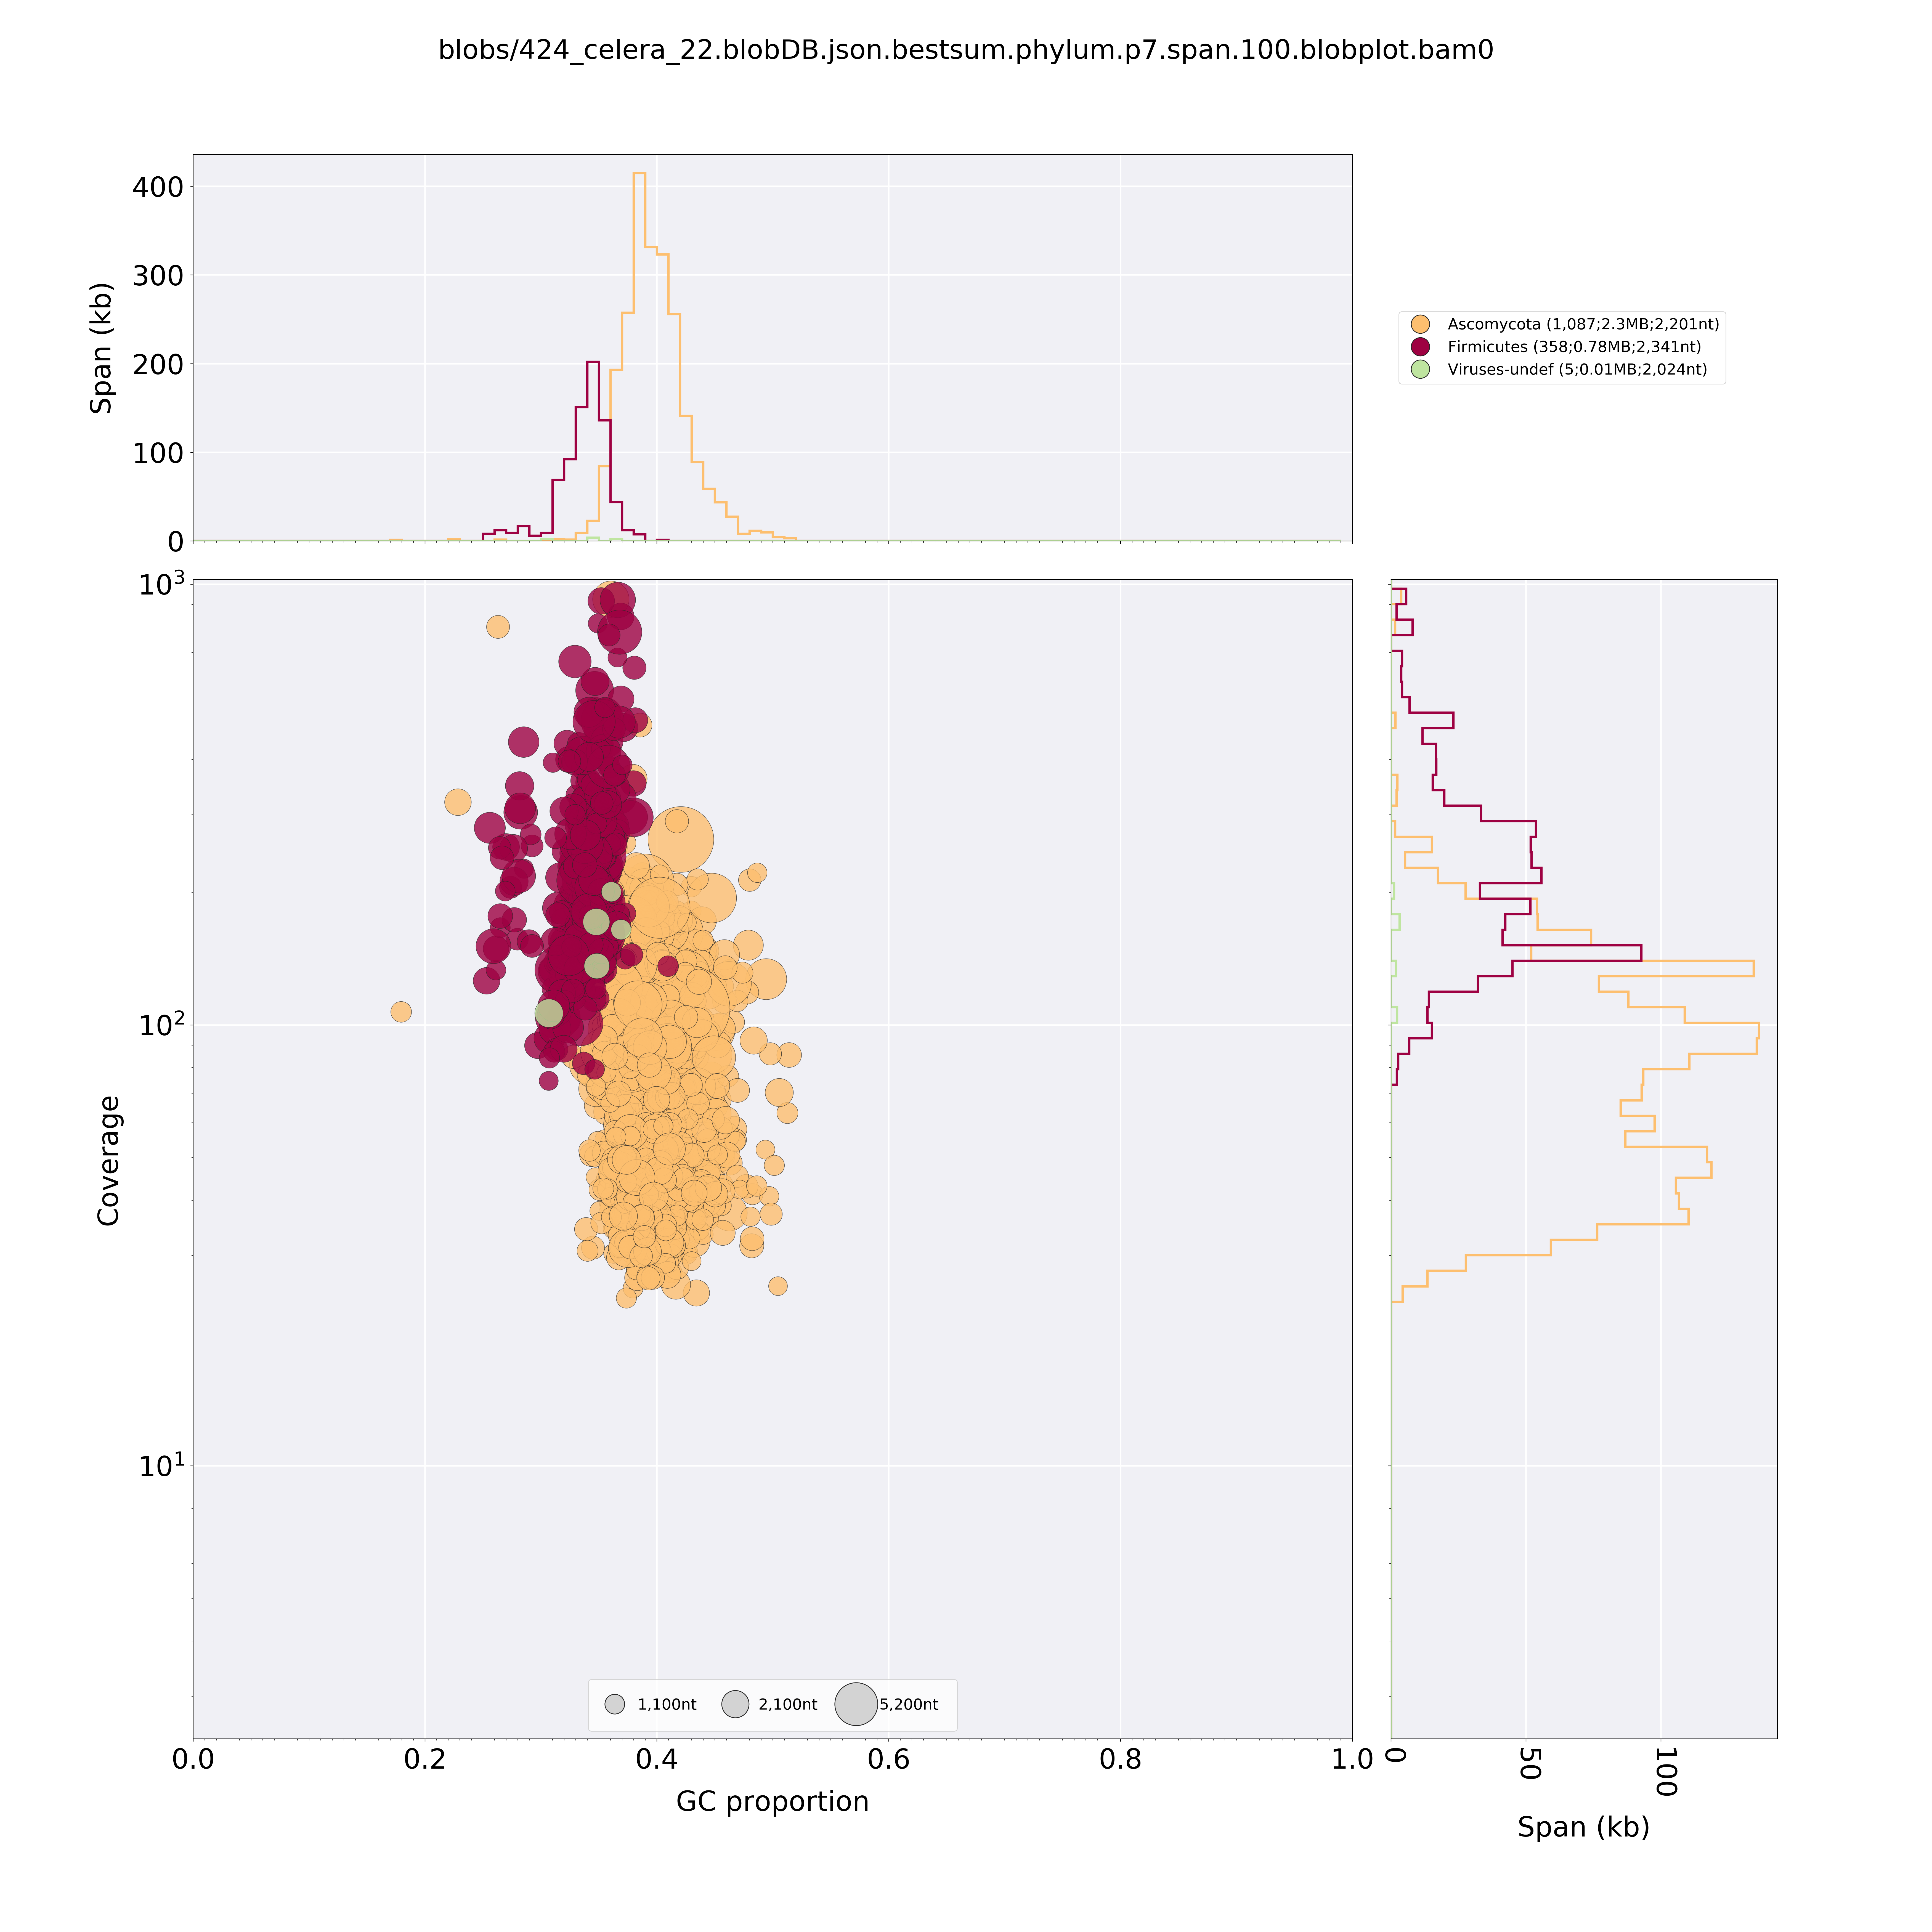

In [30]:
Image('blobs/424_celera_22.blobDB.json.bestsum.phylum.p7.span.100.blobplot.bam0.png',width=1000)

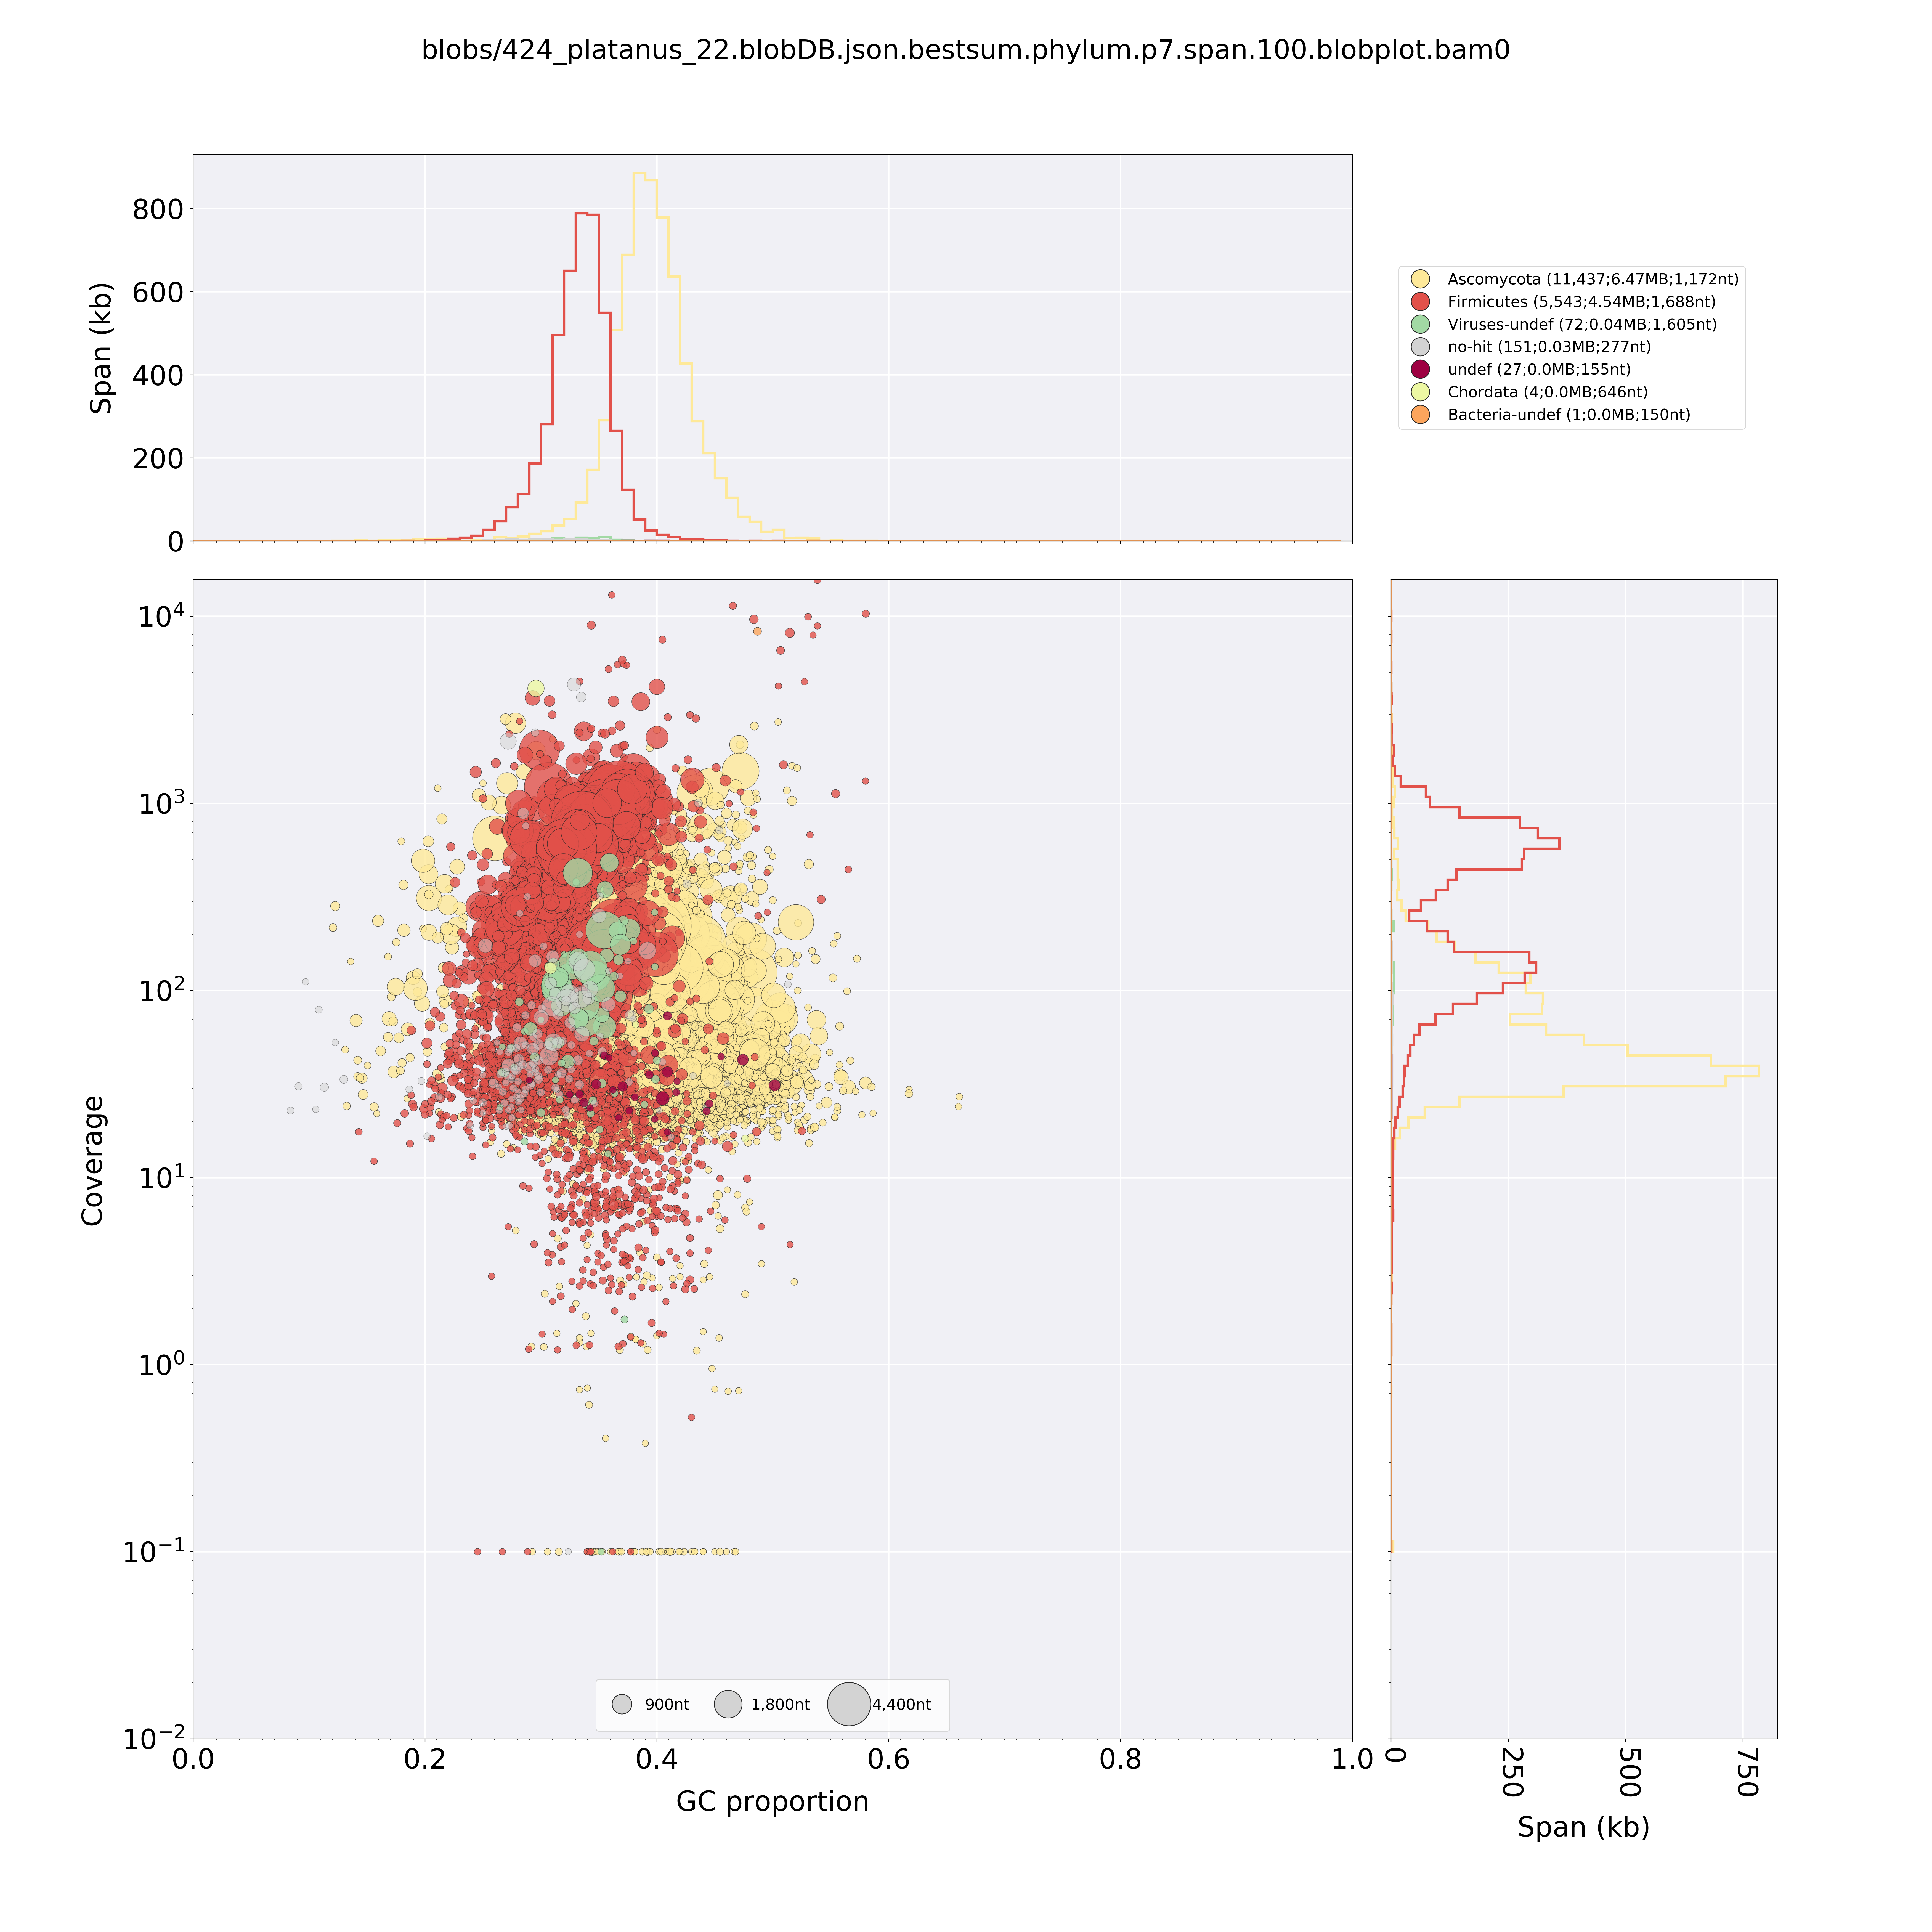

In [29]:
Image('blobs/424_platanus_22.blobDB.json.bestsum.phylum.p7.span.100.blobplot.bam0.png',width=1000)

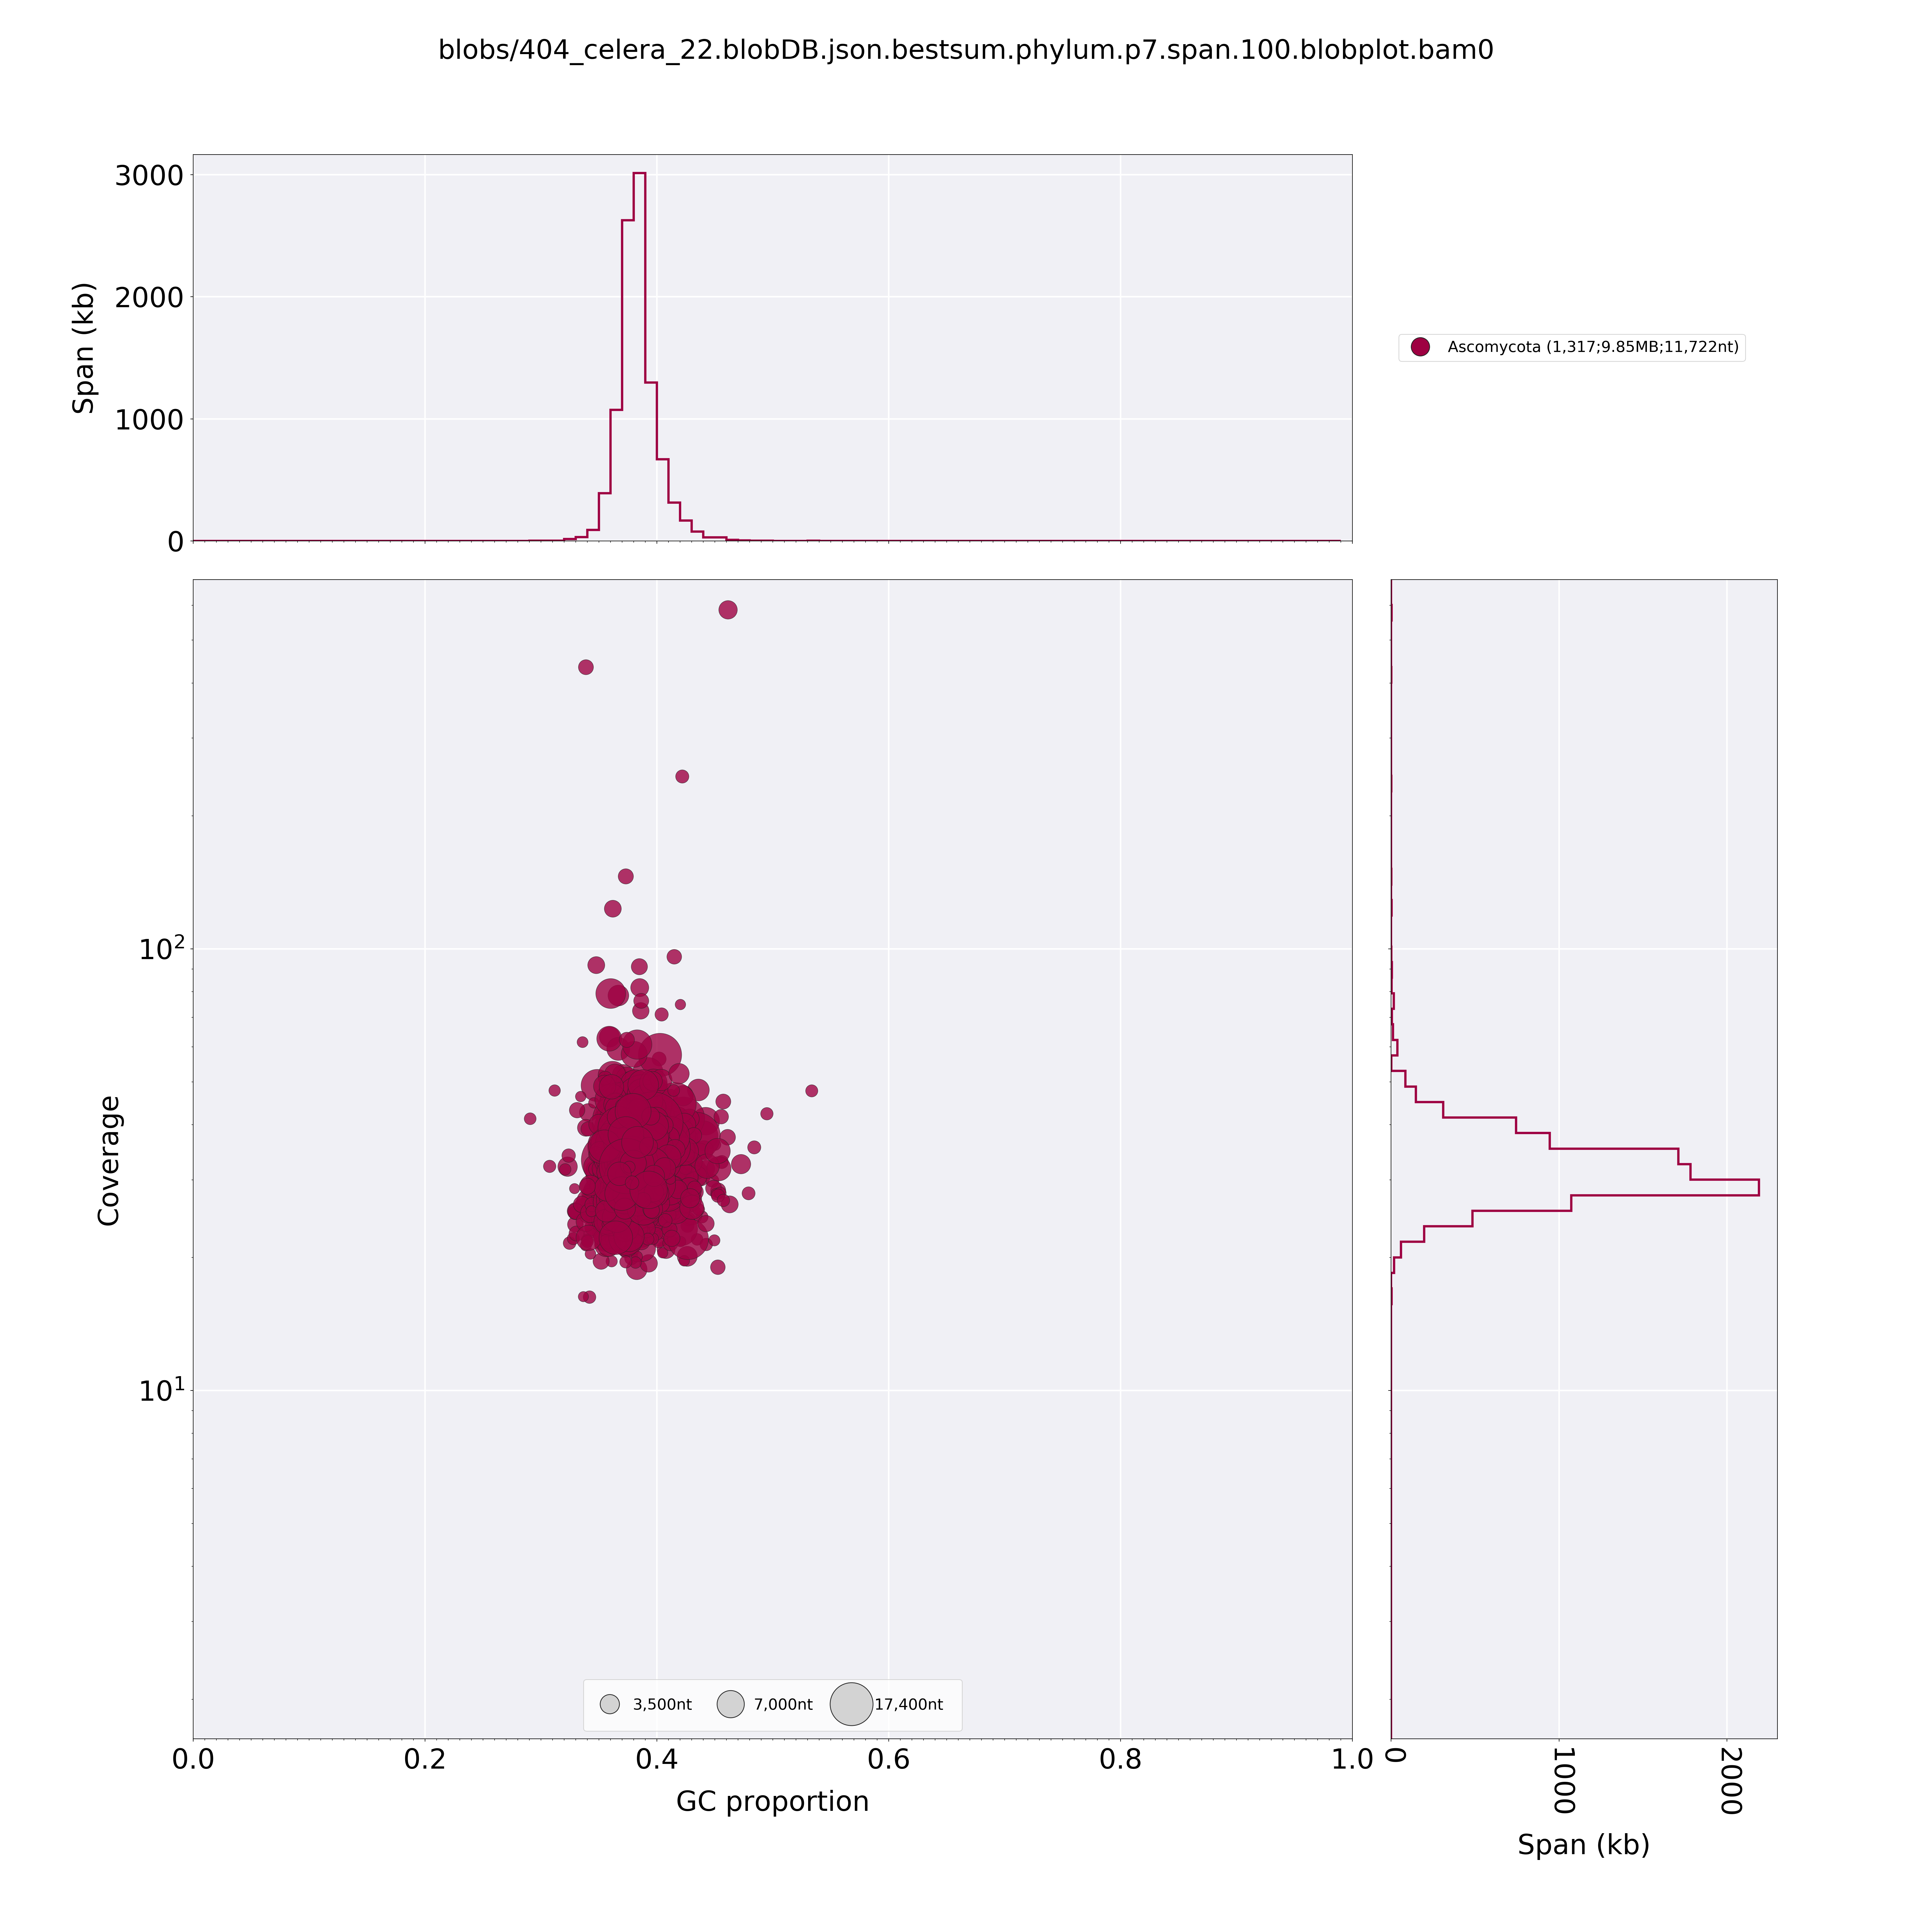

In [32]:
Image('blobs/404_celera_22.blobDB.json.bestsum.phylum.p7.span.100.blobplot.bam0.png',width=1000)

### 7. Assembly statistics

In [35]:
def assembly_length(assembly):
    return sum([len(r) for r in SeqIO.parse(assembly,'fasta')])

def assembly_gc(assembly):
    atgc = {'A':0,'T':0,'G':0,'C':0}
    
    for r in SeqIO.parse(assembly,'fasta'):
        for i in str(r.seq):
            try:
                atgc[i.upper()] += 1
            except:
                pass
            
    length = assembly_length(assembly)
    
    return 100*((atgc['G']+atgc['C'])/float(length))

def max_contig_length(assembly):
    return max([len(r) for r in SeqIO.parse(assembly,'fasta')])

def min_contig_length(assembly):
    return min([len(r) for r in SeqIO.parse(assembly,'fasta')])

def median_contig_length(assembly):
    return np.median([len(r) for r in SeqIO.parse(assembly,'fasta')])

def n50(assembly):
    return np.median(list(chain(*[[len(r)]*len(r) for r in SeqIO.parse(assembly,'fasta')])))

def coverage(assembly, blob_db):
    
    scaffolds =[r.id for r in SeqIO.parse(assembly,'fasta')]
    length = assembly_length(assembly)
    
    base_coverages = 0

    blobs =  pd.read_table(blob_db, skiprows=10, index_col=0)
    
    for scaffold in scaffolds:
        
        base_coverages += blobs.at[scaffold,'length']*blobs.at[scaffold,'bam0']
        
    return base_coverages/float(length)

statistics = pd.DataFrame(columns=['Isolate',
                                   'Program',
                                   'Mer size (bp)',
                                   'Filtered',
                                   'Length (bp)',
                                   'Max (bp)',
                                   'Min (bp)',
                                   'Median (bp)',
                                   'N50 (bp)', 
                                   'GC (%)',
                                   'Mean coverage'])

functions = [assembly_length,max_contig_length,min_contig_length,
             median_contig_length,n50,assembly_gc]

assemblies = list(glob.glob('celera_assemblies/*.mer*.scf*fasta'))
assemblies += list(glob.glob('platanus_assemblies/*_*_gapClosed*fa'))

for assembly in  assemblies:
    prog = assembly.split('_')[0]
    smpl = assembly.split('/')[-1].split('.')[0].split('_')[0]
    mer = None
    if prog == 'platanus':
        mer = assembly.split('/')[-1].split('_')[1]
    elif prog == 'celera':
        mer = assembly.split('/')[-1].split('.')[1].replace('mer','')
        
    filtered = 'None'
    if 'blobbed_by_GcCov' in assembly:
        filtered = 'by taxonomy, coverage and GC content'
    elif 'blobbed_by_taxa' in assembly:
        filtered = 'by taxonomy'
        
        
    blob_db = 'blobs/%s_%s_%s.blobDB.table.txt' % (smpl,prog,mer)
    
    values = [smpl,prog,mer,filtered]
    
    for f in functions:
        values += [f(assembly)]
        
    values += [coverage(assembly,blob_db)]
    
    statistics.loc[assembly] = values

int_cols = ['Mer size (bp)',
            'Length (bp)',
            'Max (bp)',
            'Min (bp)',
            'Median (bp)',
            'GC (%)',
            'N50 (bp)', 
            'Mean coverage'
           ]
    
for col in int_cols:
    statistics[col] = statistics[col].astype(int)

statistics = statistics.sort_values(['Isolate','Program','Mer size (bp)','Filtered'])

statistics.to_excel('assembly_statistics.xlsx')

statistics

Isolate   Program  \
celera_assemblies/404.mer22.scf.fasta                  404    celera   
platanus_assemblies/404_22_gapClosed.fa                404  platanus   
celera_assemblies/424.mer22.scf.fasta                  424    celera   
celera_assemblies/424.mer22.scf.blobbed_by_taxa...     424    celera   
celera_assemblies/424.mer22.scf.blobbed_by_GcCo...     424    celera   
platanus_assemblies/424_22_gapClosed.fa                424  platanus   
platanus_assemblies/424_22_gapClosed.blobbed_by...     424  platanus   
platanus_assemblies/424_22_gapClosed.blobbed_by...     424  platanus   
celera_assemblies/Sefale.mer22.scf.fasta            Sefale    celera   
platanus_assemblies/Sefale_22_gapClosed.fa          Sefale  platanus   

                                                    Mer size (bp)  \
celera_assemblies/404.mer22.scf.fasta                          22   
platanus_assemblies/404_22_gapClosed.fa                        22   
celera_assemblies/424.mer22.scf.fasta                          22   
celera_assemblies/424.mer22.scf.blobbed_by_taxa...             22   
celera_assemblies/424.mer22.scf.blobbed_by_GcCo...             22   
platanus_assemblies/424_22_gapClosed.fa                        22   
platanus_assemblies/424_22_gapClosed.blobbed_by...             22   
platanus_assemblies/424_22_gapClosed.blobbed_by...             22   
celera_assemblies/Sefale.mer22.scf.fasta                       22   
platanus_assemblies/Sefale_22_gapClosed.fa                     22   

                                                                                Filtered  \
celera_assemblies/404.mer22.scf.fasta                                               None   
platanus_assemblies/404_22_gapClosed.fa                                             None   
celera_assemblies/424.mer22.scf.fasta                                               None   
celera_assemblies/424.mer22.scf.blobbed_by_taxa...                           by taxonomy   
celera_assemblies/424.mer22.scf.blobbed_by_GcCo...  by taxonomy, coverage and GC content   
platanus_assemblies/424_22_gapClosed.fa                                             None   
platanus_assemblies/424_22_gapClosed.blobbed_by...                           by taxonomy   
platanus_assemblies/424_22_gapClosed.blobbed_by...  by taxonomy, coverage and GC content   
celera_assemblies/Sefale.mer22.scf.fasta                                            None   
platanus_assemblies/Sefale_22_gapClosed.fa                                          None   

                                                    Length (bp)  Max (bp)  \
celera_assemblies/404.mer22.scf.fasta                   9848269     69489   
platanus_assemblies/404_22_gapClosed.fa                11374805     15606   
celera_assemblies/424.mer22.scf.fasta                   3081440     20772   
celera_assemblies/424.mer22.scf.blobbed_by_taxa...      2297003     20772   
celera_assemblies/424.mer22.scf.blobbed_by_GcCo...      2281212     20772   
platanus_assemblies/424_22_gapClosed.fa                11091236     17222   
platanus_assemblies/424_22_gapClosed.blobbed_by...      6504539     17222   
platanus_assemblies/424_22_gapClosed.blobbed_by...      6414958     17222   
celera_assemblies/Sefale.mer22.scf.fasta                9782105     50237   
platanus_assemblies/Sefale_22_gapClosed.fa             11141141     18315   

                                                    Min (bp)  Median (bp)  \
celera_assemblies/404.mer22.scf.fasta                   1006         4973   
platanus_assemblies/404_22_gapClosed.fa                  100          967   
celera_assemblies/424.mer22.scf.fasta                   1001         1631   
celera_assemblies/424.mer22.scf.blobbed_by_taxa...      1001         1603   
celera_assemblies/424.mer22.scf.blobbed_by_GcCo...      1001         1611   
platanus_assemblies/424_22_gapClosed.fa                  100          275   
platanus_assemblies/424_22_gapClosed.blobbed_by...       100          242   
platanus_assemblies/4

### 8. Ploidy - smudgeplots

In [38]:
!mkdir smudgeplot_files

log = open('smudgeplot_files/log','wt')

for f in glob.glob('raw_reads/*_forward.paired.fastq.gz'):
    
    smpl = f.split('/')[-1].split('_')[0]
    r = f.replace('forward','reverse')
    jf = 'smudgeplot_files/%s_kmer_counts.jf' % smpl
    histfile = 'smudgeplot_files/%s_kmer_counts.hist' % smpl
    kmer_pairs = 'smudgeplot_files/%s_kmer_counts.kmer_pairs' % smpl
    kmer_pairs_coverages = 'smudgeplot_files/%s_kmer_counts.kmer_pairs_coverages_2.tsv' % smpl
    sm_output = 'smudgeplot_files/%s' % smpl
    
    a = !jellyfish count -C -m 21 -s 1000000000 -t 8 -o $jf <(zcat $f) <(zcat $r)
    for l in a:
        log.write('[%s|jellyfish count] %s\n' % (smpl, l))
    b = !jellyfish histo $jf > $histfile
    for l in b:
        log.write('[%s|jellyfish histo] %s\n' % (smpl, l))
    L=!kmer_cov_cutoff.R $histfile L
    U=!kmer_cov_cutoff.R $histfile U
    L = int(L[0])
    U = int(U[0])
    log.write('[%s|L U] %i %i\n' % (smpl, L, U))
    c = !jellyfish dump -c -L $L -U $U $jf | hetkmers.py -k 21 -t 8 -o $kmer_pairs
    for l in c:
        log.write('[%s|jellyfish dump] %s\n' % (smpl, l))
    cline = 'smudgeplot.R -i %s -o %s -t "%s"' % (kmer_pairs_coverages, sm_output,smpl)
    p = Popen(cline, shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()
    for l in out.splitlines():
        log.write('[%s|sudgeplot out] %s\n' % (smpl, l))
    for l in err.splitlines():
        log.write('[%s|sudgeplot err] %s\n' % (smpl, l))
    
log.close()

### 9. Ploidy inference by smudgeplot
404 is diploid  
424 is diploid, with haploid contamination(see above), the assmbly used downstreem was cleaned of the contamination  
SefAle is tetraploid

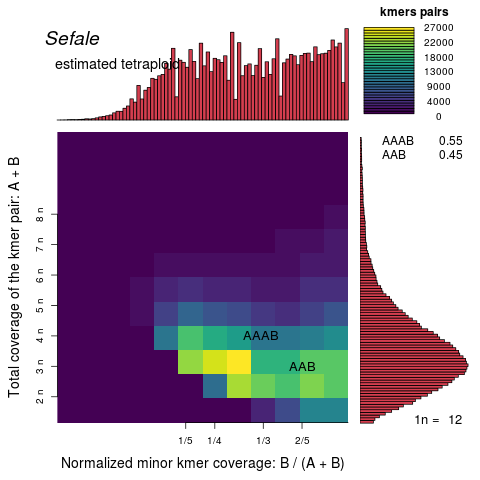

In [40]:
Image('smudgeplot_files/Sefale_smudgeplot.png')

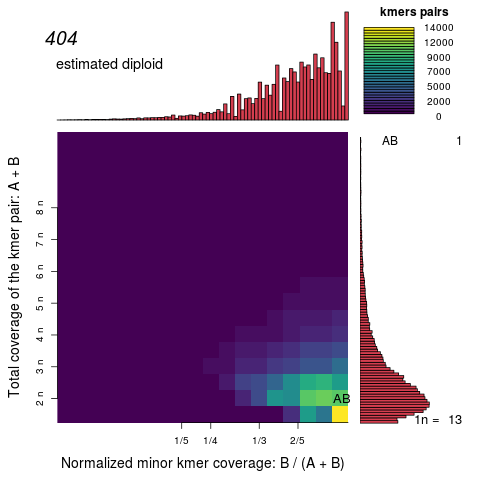

In [41]:
Image('smudgeplot_files/404_smudgeplot.png')

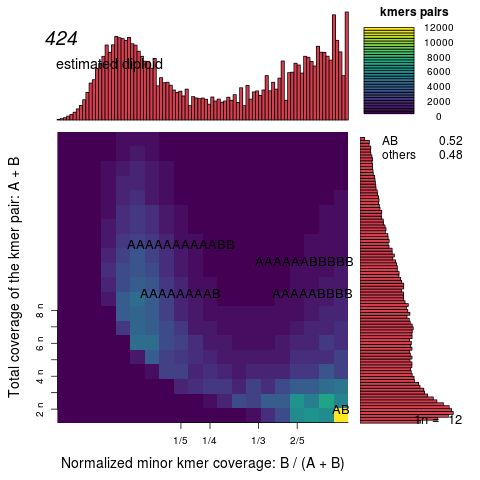

In [42]:
Image('smudgeplot_files/424_smudgeplot.png')

### 10. Map reads to reference genome
#### 10.1 Get reference genome

In [ ]:
if not path.exists('ref_genomes'):
    mkdir('ref_genomes')

url = 'ftp://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/146/045/'
url += 'GCF_000146045.2_R64/GCF_000146045.2_R64_genomic.fna.gz'

fpath = wget.download(url,'ref_genomes')

ref_assembly = fpath.replace('.gz','')

with open(ref_assembly,'wt') as hndl:
    hndl.write(gzip.open(fpath,'r').read())
remove(fpath)

#### 10.2 Map to reference

In [92]:
if not path.exists('mapping_to_ref'):
    mkdir('mapping_to_ref')

cline = "bwa index {assembly} && "
cline += "bwa mem {assembly} {read1} {read2} > {sam} && "
cline += "samtools sort -o {bam} -T {smpl} -O bam {sam} "

for read1 in glob.glob('raw_reads/*_forward.paired.fastq.gz'):
    
    smpl = read1.split('/')[-1].split('_')[0]
    
    read2 = read1.replace('forward','reverse')
    
    sam = 'mapping_to_ref/%s.sam' % smpl
    bam = 'mapping_to_ref/%s.bam' % smpl
    
    instance = cline.format(assembly=ref_assembly,read1=read1,read2=read2,sam=sam,bam=bam,smpl=smpl)
    p = Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()

#### 10.3 GC bias correction of coverage

In [ ]:
for smpl in ['404','424','Sefale']:
    bam = "mapping_to_ref/%s.bam" % smpl
    gcbias = 'mapping_to_ref/%s_gc_bias' % smpl
    corrected = 'mapping_to_ref/%s.gc_corrected.bam' % smpl
    a = !samtools index $bam
    a = !computeGCBias -b $bam \
        --effectiveGenomeSize 12000000 \
        -g ref_genomes/GCF_000146045.2_R64_genomic.2bit \
        --GCbiasFrequenciesFile $gcbias \
        -l 150
    a = !correctGCBias -b $bam \
        --effectiveGenomeSize 12000000 \
        -g ref_genomes/GCF_000146045.2_R64_genomic.2bit \
        --GCbiasFrequenciesFile $gcbias \
        -o  $corrected \
        -p 1

for smpl in ['404','424','Sefale']:
    bam = 'mapping_to_ref/%s.gc_corrected.bam' % smpl
    cov = 'mapping_to_ref/%s.gc_corrected.cov' % smpl
    a = !samtools depth -aa $bam > $cov
    !gzip $cov

#### 10.4 Plot coverage

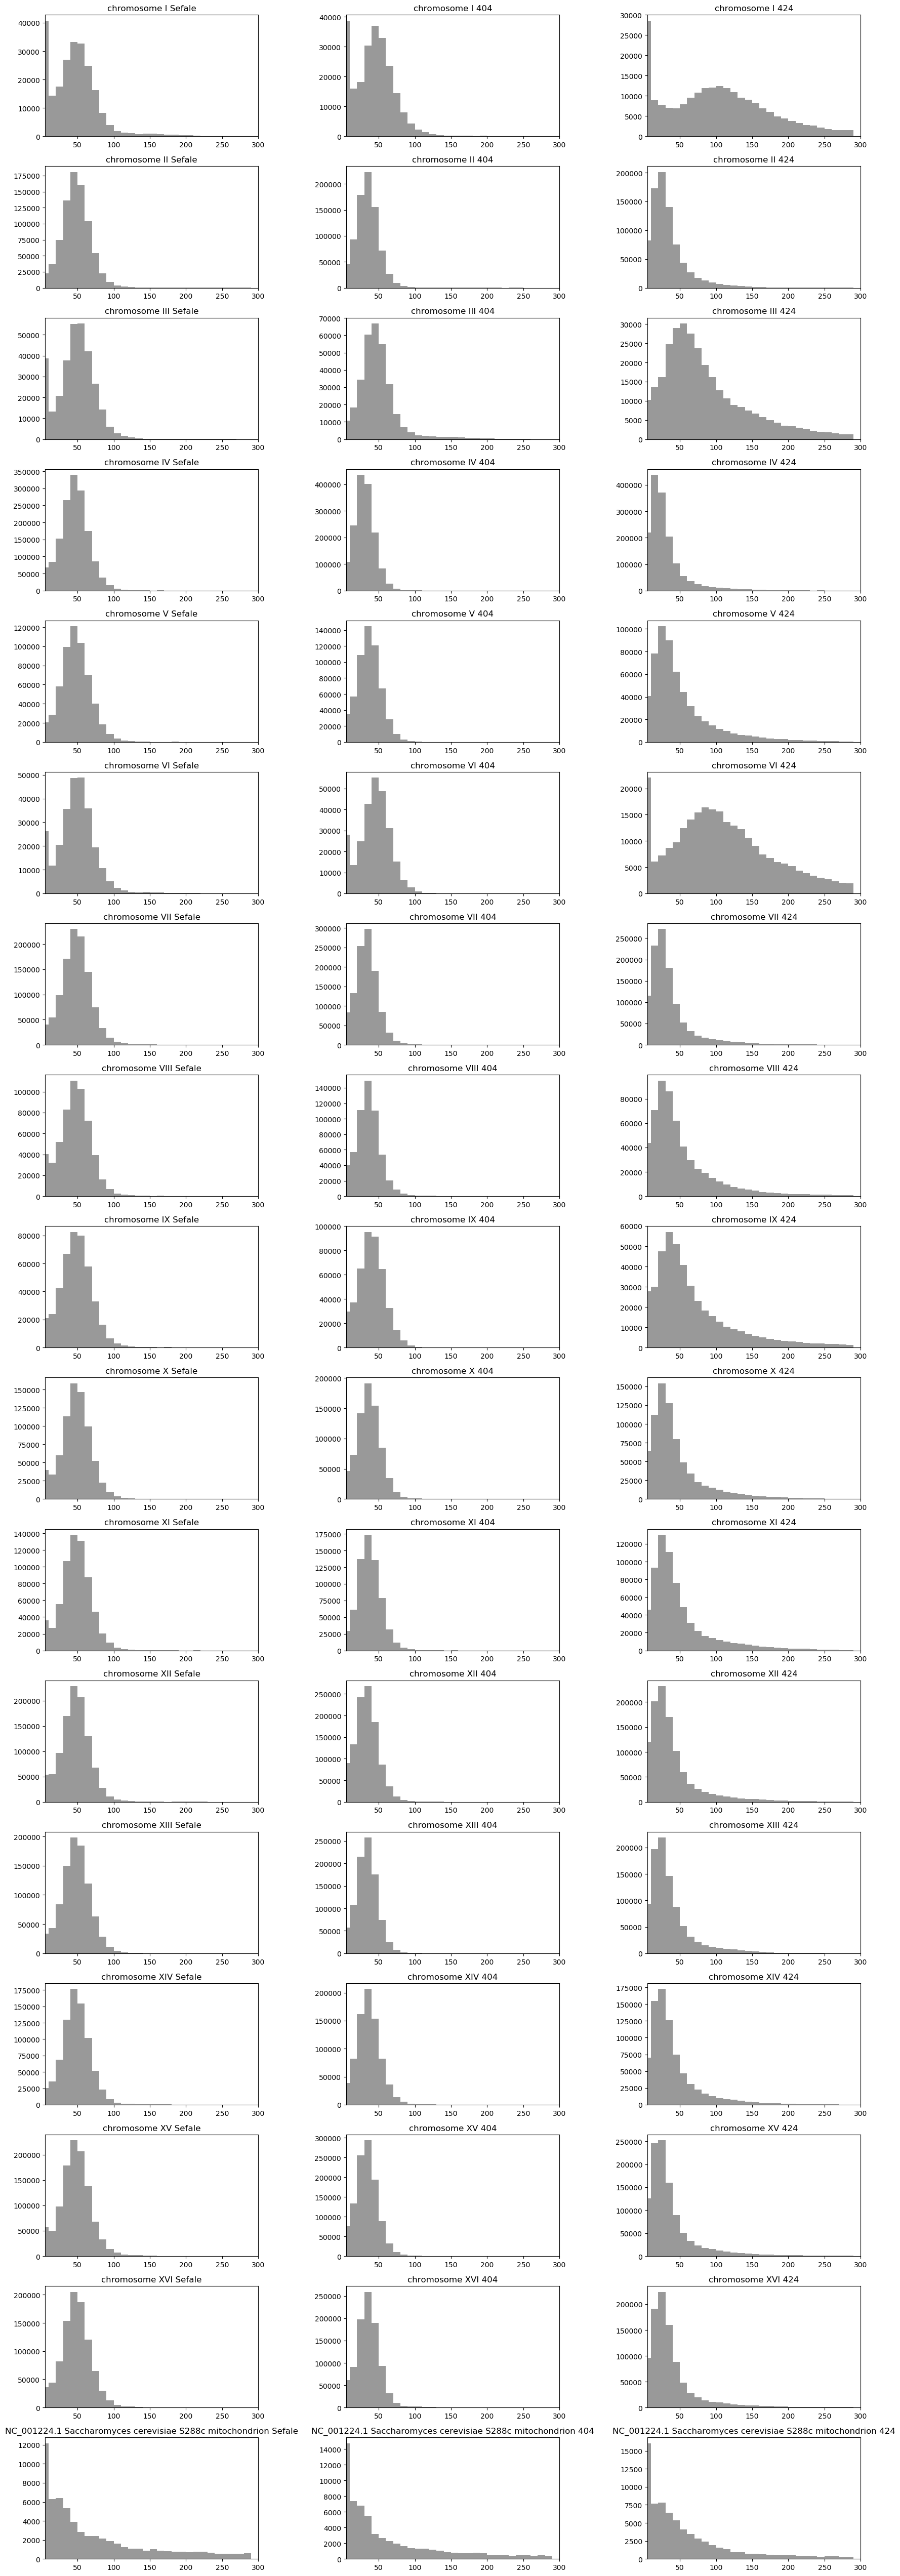

In [19]:
chro = {}

ref_genome = list(SeqIO.parse('ref_genomes/GCF_000146045.2_R64_genomic.fna','fasta'))

for r in ref_genome:
    chro[r.id] = r.description.split('S288C ')[-1].split(',')[0]

scaffs = [r.id for r in ref_genome]

gc_corrected_cov_hist = {}
for smpl in ['404','424','Sefale']:
    gc_corrected_cov_hist[smpl] = {}
    for l in gopen('mapping_to_ref/%s.gc_corrected.cov.gz' % smpl):
        scaff, pos, cov = l.rstrip().split('\t')
        if not scaff in gc_corrected_cov_hist[smpl]:
            gc_corrected_cov_hist[smpl][scaff] = []
        gc_corrected_cov_hist[smpl][scaff].append(int(cov))
        
fig, axes = plt.subplots(nrows=17,ncols=3, figsize = (18, 51), dpi=100)

rows = list(range(17))

for scaff in sorted(scaffs):
    #print scaff
    row_index = rows.pop(0)
    columns = [0,1,2]
    for smpl in gc_corrected_cov_hist:
        column_index = columns.pop(0)
        sns.distplot([int(i) for i in gc_corrected_cov_hist[smpl][scaff]],kde=False,color='black', ax=axes[row_index,column_index], bins=list(xrange(300))[0:300:10])
        
        axes[row_index,column_index].set_xlim(5,300)
        axes[row_index,column_index].set_title(chro[scaff] + ' ' + smpl)
plt.tight_layout() 

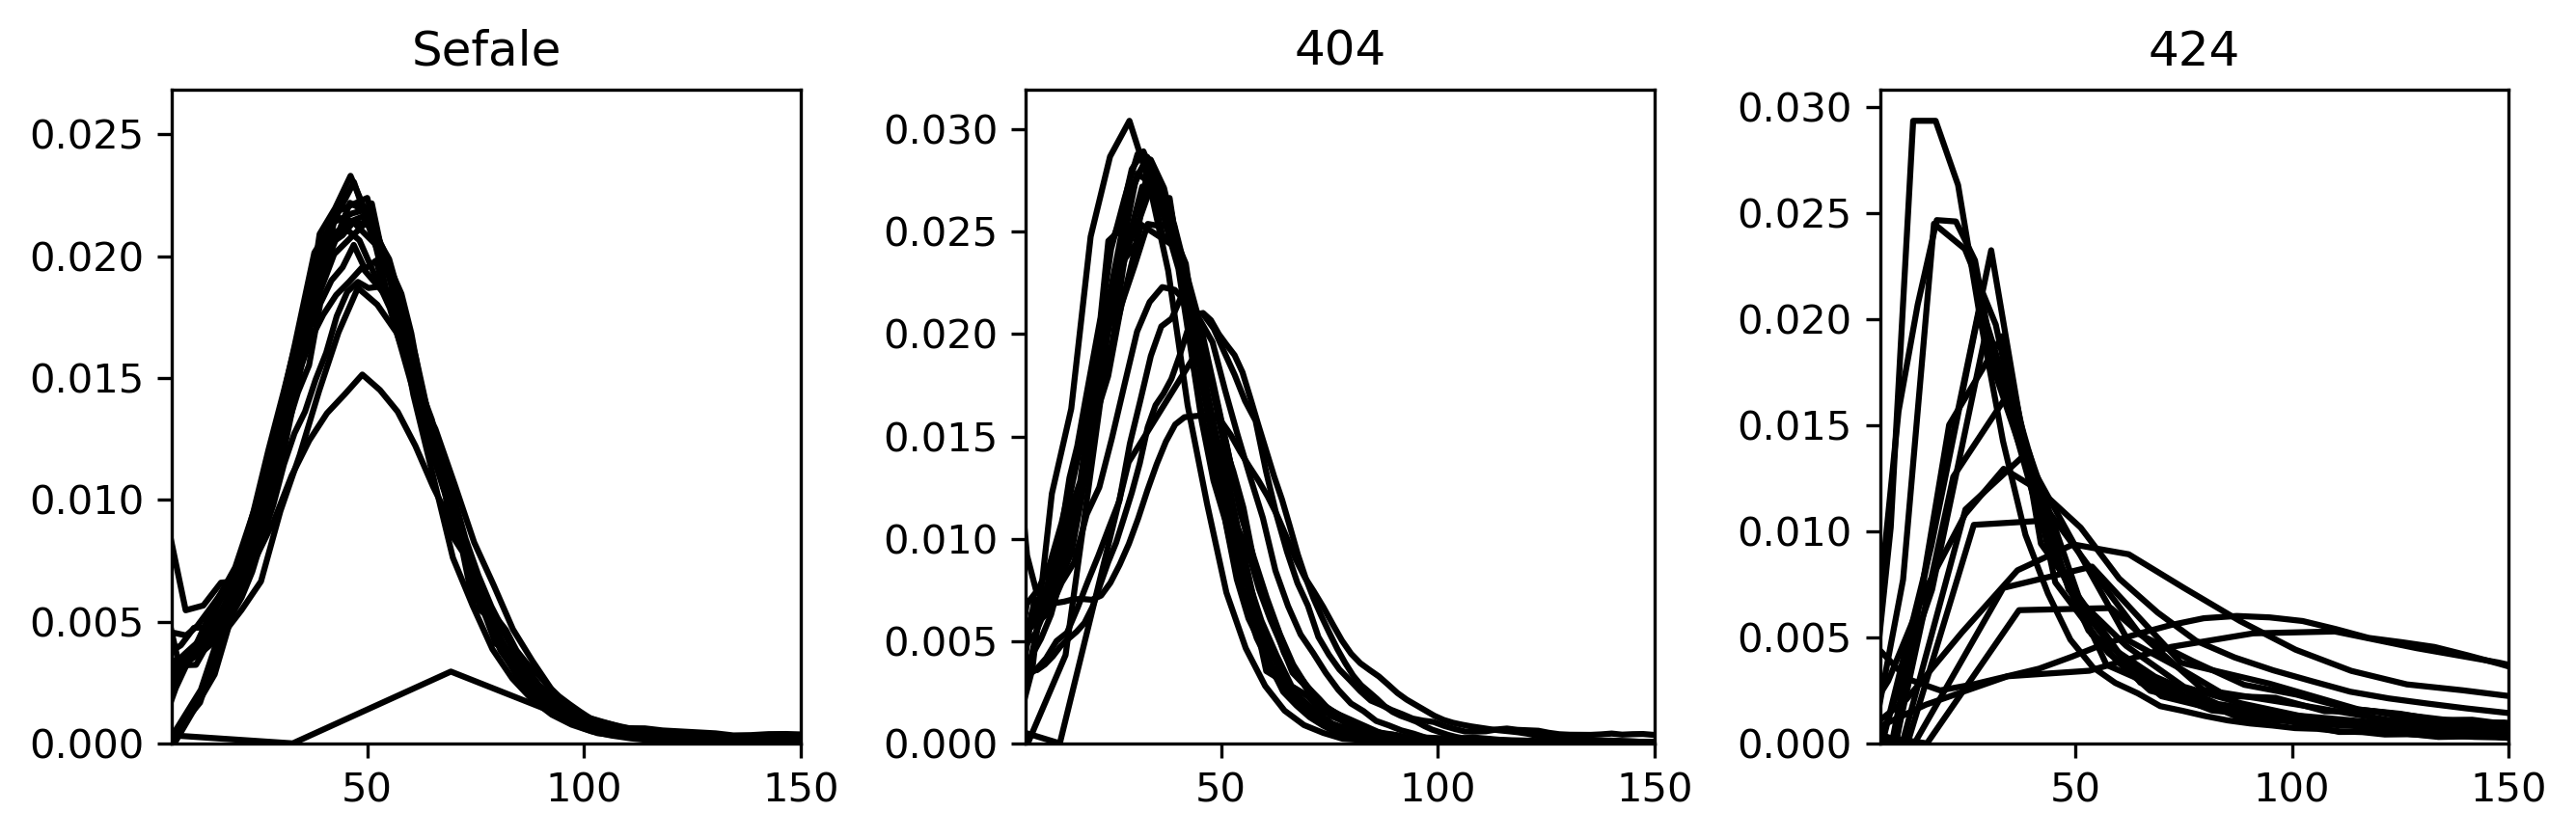

In [20]:
fig, axes = plt.subplots(nrows=1,ncols=3, figsize = (9, 3), dpi=300)

for scaff in sorted(scaffs):
    if scaff == 'NC_001224.1':
        continue

columns = [0,1,2]

for smpl in gc_corrected_cov_hist:
    
    column_index = columns.pop(0)
    
    for scaff in sorted(scaffs):
        if scaff == 'NC_001224.1':
            continue
            
        sns.distplot([int(i) for i in gc_corrected_cov_hist[smpl][scaff]],hist=False,color='black', ax=axes[column_index], bins=list(xrange(300))[0:300:10])
    axes[column_index].set_xlim(5,150)
    axes[column_index].set_title(smpl)
        
plt.tight_layout() 

### 11. SNP calling

In [ ]:
%%bash
freebayes \
-f  ref_genomes/GCF_000146045.2_R64_genomic.fna \
-p 4 \
mapping_to_ref/Sefale.gc_corrected.bam \
> mapping_to_ref/Sefale.gc_corrected.vcf

freebayes \
-f  ref_genomes/GCF_000146045.2_R64_genomic.fna \
-p 2 \
mapping_to_ref/404.gc_corrected.bam \
> mapping_to_ref/404.gc_corrected.vcf

freebayes \
-f  ref_genomes/GCF_000146045.2_R64_genomic.fna \
-p 2 \
mapping_to_ref/424.gc_corrected.bam \
> mapping_to_ref/424.gc_corrected.vcf

### 12. Functional annotation of reference genome genes

In [ ]:
eggnog = '/home/amir/eggnog-mapper-1.0.3/emapper.py'
!$eggnog -d fuNOG -o ref_genomes/GCF_000146045.2 --cpu 5 -i ref_genomes/GCF_000146045.2_R64_protein.faa

### 13. Consensus sequences for the TOR1 gene

In [ ]:
tor1_acc = eggnog.loc[eggnog.predicted_gene_name=='TOR1'].index.tolist()

for acc in tor1_acc:
    gene = gff.loc[gff['qualifiers'].str.contains(acc)]['scaffold']
    start = gff.loc[gff['qualifiers'].str.contains(acc)]['start']
    end = gff.loc[gff['qualifiers'].str.contains(acc)]['end']
    for smpl in ['404','424','Sefale']:
        outbam = 'mapping_to_ref/%s.TOR1.%s.bam' % (smpl,gene) 
        inbam = 'mapping_to_ref/%s.gc_corrected.bam' % smpl
        filter_loc = "%s:%i-%i" % (gene,start,end)
        !samtools view -O bam -o $outbam $inbam $filter_loc
        !samtools index $outbam
        
for f in glob.glob('mapping_to_ref/*.TOR1.*.bam'):
    ouf = f+'.vcf'
    !freebayes -f ref_genomes/GCF_000146045.2_R64_genomic.fna --report-monomorphic -p 4 $f > $ouf

amb = {
    'A,G':'R',
    'C,T':'Y',
    'C,G':'S',
    'A,T':'W',
    'G,T':'K',
    'A,C':'M',
    'C,G,T':'B',
    'A,G,T':'D',
    'A,C,T':'H',
    'A,C,G':'V',
    'A,C,G,T':'N'
}

def concensus(series):
    ref = series['REF']
    if series['ALT'] == '.':
        return ref
    try:
        alt = series['ALT'].split(',')
        af = [float(j) for j in {i.split('=')[0]:i.split('=')[1] for i in series['INFO'].split(';')}['AF'].split(',')]
    except:
        return ref
    if len(alt) == 1 and af[0] == 1:
        if any([len(i) != len(alt[0]) for i in alt]):
            print ref, alt
            return ref
        return alt[0]
    states = []
    if len(alt) > 0 and sum(af) == 1:
        states = alt
    elif len(alt) > 0 and sum(af) < 1:
        if any([len(i) != len(ref) for i in alt]):
            print ref, alt
            return ref
        states = [ref]+alt
        
    max_states_size = max([len(i) for i in states])
    for i in range(len(states)):
        if len(states[i]) < max_states_size:
            diff = max_states_size-len(states[i])
            states[i] += ''.join(['-']*diff)
        
    con = ''
    
    for i in range(len(states[0])):
        posstates = sorted(list(set([s[i] for s in states])))
        posstates = [i for i in posstates if not i =='-']
        if len(posstates) == 1:
            con += posstates[0]
        else:
            con += amb[','.join(posstates)]

    return con

with open('mapping_to_ref/TOR1_consensus_sequences.fasta','wt') as hndl:
    for f in glob.glob('mapping_to_ref/*.TOR1.*.bam.vcf'):
        df = pd.read_table(f,skiprows=76)
        l = df.POS.tolist()
        df['concensus'] = df.apply(concensus,axis=1)
        df.to_csv('%s_with_charstates.tsv' % f ,sep='\t',index=False)
        hndl.write('>%s\n' % f)
        hndl.write('%s\n' % ''.join(df.concensus.tolist()))

### 14. Map SefAle, 404 and 402 to SefAle

In [21]:
ref_assembly = 'celera_assemblies/Sefale.mer22.scf.fasta'

if not path.exists('mapping_to_SefAle'):
    mkdir('mapping_to_SefAle')



cline = ""
cline += "bwa index {assembly} && "
cline += "bwa mem {assembly} {read1} {read2} > {sam} && "
cline += "samtools sort -o {bam} -T {smpl} -O bam {sam} && "
cline += "samtools depth -aa {bam} > {cov} && "
cline += "samtools view -f 4 {bam} > {un}"

for read1 in glob.glob('raw_reads/*_forward.paired.fastq.gz'):
    
    smpl = read1.split('/')[-1].split('_')[0]
    
    read2 = read1.replace('forward','reverse')
    
    sam = 'mapping_to_SefAle/%s.sam' % smpl
    bam = 'mapping_to_SefAle/%s.bam' % smpl
    cov = 'mapping_to_SefAle/%s.cov' % smpl
    un = 'mapping_to_SefAle/%s.un.sam' % smpl
    
    if path.exists(bam) or path.exists(cov+'.gz'):
        continue
    
    instance = cline.format(assembly=ref_assembly,read1=read1,read2=read2,sam=sam,bam=bam,smpl=smpl,cov=cov,un=un)
    p = Popen(instance,shell=True,stdout=PIPE,stderr=PIPE)
    out, err = p.communicate()

### 15. SNPs in SefAle, 404 and 424 compared to SefAle

In [23]:
%%bash

mkdir snps_sefale

freebayes \
-f  celera_assemblies/Sefale.mer22.scf.fasta \
-p 2 \
mapping_to_SefAle/404.bam \
> snps_sefale/404.vcf

freebayes \
-f  celera_assemblies/Sefale.mer22.scf.fasta \
-p 2 \
mapping_to_SefAle/424.bam \
> snps_sefale/424.vcf

freebayes \
-f  celera_assemblies/Sefale.mer22.scf.fasta \
-p 4 \
mapping_to_SefAle/Sefale.bam \
> snps_sefale/Sefale.vcf

mkdir: cannot create directory ‘snps_sefale’: File exists


### 16. identify genes in SefAle

In [ ]:
annotate = 'zcat reference_transcripts/GCF_000146045.2_R64_rna.fna.gz > GCF_000146045.2_R64_rna.fna && '
annotate += 'blat -minIdentity=92 celera_assemblies/Sefale.mer22.scf.fasta '
annotate += 'GCF_000146045.2_R64_rna.fna Sefale.psl && '
annotate += 'blat2hints.pl --in=Sefale.psl --out=Sefale_hints.E.gff && ' 
annotate += 'augustus --species=saccharomyces '
annotate += '--hintsfile=Sefale_hints.E.gff '
annotate += '--extrinsicCfgFile=extrinsic.ME.cfg --gff3=on '
annotate += 'celera_assemblies/Sefale.mer22.scf.fasta > celera_assemblies/Sefale.gff3 && '
annotate += 'rm GCF_000146045.2_R64_rna.fna'


p = Popen(annotate, shell=True, stdout=PIPE, stderr=PIPE)
out, err =  p.communicate()

### 17. Write fastas and gff for SafAle

In [ ]:
def mkgff3(smpl):
    with open(smpl+'.gff','wt') as hndl:
        for l in open(smpl+'.gff3','r'):
            if not l.startswith('#'):
                hndl.write(l)
                
def dump_fastas(genome):
    from Bio import SeqIO

    annotation = genome + '.gff'
    assembly = genome

    prot_out = assembly+'.proteins.fasta'
    cds_out = assembly+'.cds.fasta'
    gene_out = assembly+'.nt.fasta'

    gene_hndl = open(gene_out,'wt')
    cds_hndl = open(cds_out,'wt')
    prot_hndl = open(prot_out,'wt')

    records = SeqIO.to_dict(SeqIO.parse(assembly,'fasta'))
    annotation_hndl = open(annotation,'r')

    gene_id = None
    cds_seq = None
    gene_seq = None

    for gff in annotation_hndl:
        contig, a, featuretype, start, end, b, strand, c, qualifiers = \
        gff.split('\t')

        start = int(start)
        end = int(end)

        qualifiers = {q.split('=')[0]: q.split('=')[1] for
                          q in qualifiers.rstrip().split(';') if q}

        start -= 1

        if not 'ID' in qualifiers:
            continue

        if not gene_id and featuretype == 'gene':
            gene_id = qualifiers["ID"]
            gene_seq = records[contig].seq[start:end]
            if strand == '-':
                gene_seq = gene_seq.reverse_complement()
            gene_hndl.write('>%s\n%s\n'%(gene_id, str(gene_seq)))

        elif (gene_id and 
            not gene_id == qualifiers['ID'].split('.')[0] and 
            featuretype == 'gene'):

            cds_hndl.write('>%s\n%s\n'%(gene_id, str(cds_seq)))
            prot_seq = str(cds_seq.translate())
            if prot_seq.endswith('*'):
                prot_seq = prot_seq[:-1]
            prot_hndl.write('>%s\n%s\n'%(gene_id, prot_seq))

            cds_seq = None
            prot_seq = None

            gene_id = qualifiers["ID"]
            gene_seq = records[contig].seq[start:end]
            if strand == '-':
                gene_seq = gene_seq.reverse_complement()
            gene_hndl.write('>%s\n%s\n'%(gene_id, str(gene_seq)))

        elif featuretype == 'CDS' and qualifiers['ID'].split('.')[0] == gene_id:
            if not cds_seq:
                cds_seq = ''
            exon_seq = records[contig].seq[start:end]
            if strand == '+':
                cds_seq += exon_seq
            elif strand == '-':
                cds_seq = exon_seq.reverse_complement() + cds_seq
            else:
                raise RuntimeError('dont know strand %s'%strand)
    if cds_seq:
        cds_hndl.write('>%s\n%s\n'%(gene_id, str(cds_seq)))
        prot_seq = str(cds_seq.translate())
        if prot_seq.endswith('*'):
            prot_seq = prot_seq[:-1]
        prot_hndl.write('>%s\n%s\n'%(gene_id, prot_seq))

    annotation_hndl.close()
    gene_hndl.close()
    cds_hndl.close()
    prot_hndl.close()
    

mkgff3('celera_assemblies/Sefale')
dump_fastas('celera_assemblies/Sefale.mer22.scf.fasta')

### 18. Functional annotation SefAle

In [ ]:
emapper = '/home/amir/eggnog-mapper-0.99.3/emapper.py'
cline = "python %s -i celera_assemblies/Sefale.mer22.scf.fasta.proteins.fasta --output celera_assemblies/Sefale -d ascNOG --usemem --cpu 7" % emapper
p = Popen(cline, shell=True, stdout=PIPE, stderr=PIPE)
out, err = p.communicate()

### 19. Summarize polymorphism in 404, 424 compared to SefAle

In [2]:
sefale = SeqIO.to_dict(SeqIO.parse('celera_assemblies/Sefale.mer22.scf.fasta','fasta'))

def read_vcf(fpath):
    return pd.read_table(fpath,skiprows=1030)

def get_DP(info_string):
    parts = info_string.split(';')
    info = {i.split('=')[0]: i.split('=')[1] for i in parts}
    return int(info['DP'])

def get_type(info_string):
    parts = info_string.split(';')
    info = {i.split('=')[0]: i.split('=')[1] for i in parts}
    return info['TYPE']

def good_DP(info_string):
    parts = info_string.split(';')
    info = {i.split('=')[0]: i.split('=')[1] for i in parts}
    return int(info['DP']) >= 30

def is_heterozygote(info_string):
    parts = info_string.split(';')
    info = {i.split('=')[0]: i.split('=')[1] for i in parts}
    proportions = [float(i) for i in info['AF'].split(',')]
    if sum(proportions) < 1 or len(proportions) > 1:
        return "True"
    return "False"

def sefale_is_heterozygote(series):
    pos_df = sefale_vcf.loc[((sefale_vcf['#CHROM'] == series['#CHROM']) & (sefale_vcf['POS'] == series['POS']) & (sefale_vcf['good_DP'] == True))]
    if len(pos_df) == 0:
        return False
    else:
        return pos_df['Heterozygote'].tolist()[0]
    
def get_state(series):
    info_string = series['INFO']
    parts = info_string.split(';')
    info = {i.split('=')[0]: i.split('=')[1] for i in parts}
    proportions = [float(i) for i in info['AF'].split(',')]
    states = series['ALT']
    if sum(proportions) < 1:
        states += ','+series['REF']
    return states
        
def get_sefale_state(series):
    pos_df = sefale_vcf.loc[((sefale_vcf['#CHROM'] == series['#CHROM']) & (sefale_vcf['POS'] == series['POS']) & (sefale_vcf['good_DP'] == True))]
    if len(pos_df) == 0:
        return str(sefale[series['#CHROM']].seq)[series['POS']-1]
    return pos_df['states'].tolist()[0]
    
fpath='snps_sefale/Sefale.vcf'

sefale_vcf = read_vcf(fpath)
sefale_vcf['DP'] = sefale_vcf.INFO.apply(get_DP)
sefale_vcf['good_DP'] = sefale_vcf.INFO.apply(good_DP)
sefale_vcf['TYPE'] = sefale_vcf.INFO.apply(get_type)
sefale_vcf['Heterozygote'] = sefale_vcf.INFO.apply(is_heterozygote)
sefale_vcf['states'] = sefale_vcf.apply(get_state, axis=1)

all_poly = sefale_vcf.loc[sefale_vcf.good_DP==True][['#CHROM','POS','REF','ALT','DP','TYPE','Heterozygote','states']]

f = open('snps_sefale/Sefale_all_polymorphism.tsv', 'a')
f.write('# SefAle mapped to SefAle, all polymorphism\n')
f.write('# Entries with coverage < 30 not shown\n')
all_poly.to_csv(f, sep='\t',index=False)
f.close()

fpath='snps_sefale/404.vcf'

vcf = read_vcf(fpath)
vcf['DP'] = vcf.INFO.apply(get_DP)
vcf['good_DP'] = vcf.INFO.apply(good_DP)
vcf['TYPE'] = vcf.INFO.apply(get_type)
vcf['Heterozygote'] = vcf.INFO.apply(is_heterozygote)
vcf['SefAle_Heterozygote'] = vcf.apply(sefale_is_heterozygote,axis=1)
vcf['states'] = vcf.apply(get_state, axis=1)
vcf['SefAle_states'] = vcf.apply(get_sefale_state, axis=1)

all_poly = vcf.loc[((vcf.good_DP==True) & (vcf.states != vcf.SefAle_states))][['#CHROM','POS','REF','ALT','DP','TYPE','Heterozygote','SefAle_Heterozygote','states','SefAle_states']]

f = open('snps_sefale/404_all_polymorphism.tsv', 'a')
f.write('# 404 mapped to SefAle, all polymorphism\n')
f.write('# Entries with coverage < 30 not shown\n')
all_poly.to_csv(f, sep='\t',index=False)
f.close()

fpath='snps_sefale/424.vcf'

vcf = read_vcf(fpath)
vcf['DP'] = vcf.INFO.apply(get_DP)
vcf['good_DP'] = vcf.INFO.apply(good_DP)
vcf['TYPE'] = vcf.INFO.apply(get_type)
vcf['Heterozygote'] = vcf.INFO.apply(is_heterozygote)
vcf['SefAle_Heterozygote'] = vcf.apply(sefale_is_heterozygote,axis=1)
vcf['states'] = vcf.apply(get_state, axis=1)
vcf['SefAle_states'] = vcf.apply(get_sefale_state, axis=1)

all_poly = vcf.loc[((vcf.good_DP==True) & (vcf.states != vcf.SefAle_states))][['#CHROM','POS','REF','ALT','DP','TYPE','Heterozygote','SefAle_Heterozygote','states','SefAle_states']]

f = open('snps_sefale/424_all_polymorphism.tsv', 'a')
f.write('# 424 mapped to SefAle, all polymorphism\n')
f.write('# Entries with coverage < 30 not shown\n')
all_poly.to_csv(f, sep='\t',index=False)
f.close()

### 20. Add functional annotation

In [3]:
gff = 'celera_assemblies/Sefale.gff'
annot = 'celera_assemblies/Sefale.emapper.annotations'

import pandas as pd

gff_df = pd.read_table(gff, header=None, names=['scaff','prog','feature','start','end','score','strand','?','qualifiers'])

gff_df = gff_df.loc[gff_df.feature == 'gene']

def get_gene_id(string):
    return string.split('=')[1]

gff_df['gene_id'] = gff_df.qualifiers.apply(get_gene_id)
gff_df = gff_df.set_index('gene_id')

gff_df

annot_df = pd.read_table(annot, skiprows=2)

annot_df = annot_df.set_index('#query_name')

def get_gene(series):
    chrom = series['#CHROM']
    pos = series['POS']
    chrom_gff = gff_df.loc[gff_df.scaff == chrom]
    for ind, row in chrom_gff.iterrows():
        if row['start'] <= pos <= row['end']:
            return ind
    return 'no_gene'

def get_predicted_gene_name(gene):
    try:
        return annot_df.at[gene,'predicted_gene_name']
    except:
        return None
def get_GO_terms(gene):
    try:
        return annot_df.at[gene,'GO_terms']
    except:
        return None
def get_KEGG_pathways(gene):
    try:
        return annot_df.at[gene,'KEGG_pathways']
    except:
        return None
def get_COG_cat(gene):
    try:
        return annot_df.at[gene,'COG_cat']
    except:
        return None
def get_eggNOG_annot(gene):
    try:
        return annot_df.at[gene,'eggNOG_annot']
    except:
        return None

def chrom_pos(series):
    return series['#CHROM'] + '_' + str(series['POS'])

for f in glob.glob('snps_sefale/*.tsv'):
    snps_df = pd.read_table(f,skiprows=2)
    snps_df['gene'] = snps_df.apply(get_gene,axis=1)
    snps_df['predicted_gene_name'] = snps_df.gene.apply(get_predicted_gene_name)
    snps_df['GO_terms'] = snps_df.gene.apply(get_GO_terms)
    snps_df['KEGG_pathways'] = snps_df.gene.apply(get_KEGG_pathways)
    snps_df['COG_cat'] = snps_df.gene.apply(get_COG_cat)
    snps_df['eggNOG_annot'] = snps_df.gene.apply(get_eggNOG_annot)
    snps_df.to_csv(f+'.annotated.txt',sep='\t')

/home/amir/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (1,4,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 21. Detect synonymous and non-synonymous mutation

In [6]:
gff_df = pd.read_table(gff, header=None, names=['scaff','prog','feature','start','end','score','strand','?','qualifiers'])
gff_df = gff_df.loc[gff_df.feature == 'CDS']

sefale = SeqIO.to_dict(SeqIO.parse('celera_assemblies/Sefale.mer22.scf.fasta','fasta'))

table = """FFLLSSSSYY**CC*WLLLLPPPPHHQQRRRRIIIMTTTTNNKKSSRRVVVVAAAADDEEGGGG
TTTTTTTTTTTTTTTTCCCCCCCCCCCCCCCCAAAAAAAAAAAAAAAAGGGGGGGGGGGGGGGG
TTTTCCCCAAAAGGGGTTTTCCCCAAAAGGGGTTTTCCCCAAAAGGGGTTTTCCCCAAAAGGGG
TCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAGTCAG""".splitlines()

translate = {}

for i in range(len(table[0])):
    translate[table[1][i]+table[2][i]+table[3][i]] = table[0][i]

revcomp = {
    'A': 'T',
    'T': 'A',
    'G': 'C',
    'C': 'G'
}
    
def define_var(series):
    if series['SefAle_Heterozygote'] and not series['Heterozygote']:
        return 'LOH'
    if series['Heterozygote'] and not series['SefAle_Heterozygote']:
        return 'GOH'
    if series['Heterozygote'] and series['SefAle_Heterozygote']:
        return 'retained heterozygocity'
    if series['TYPE'] != 'snp':
        return 'complex mutation'
    if series['gene'] == 'no_gene':
        return 'no_gene'
    cdss = gff_df.loc[gff_df.qualifiers.str.contains('ID=%s.' % series['gene'])]
    if len(cdss) == 0:
        return 'not protein coding'
    bases = []
    for ind, row in cdss.iterrows():
        bases += list(range(row['start'],row['end']+1))
    keep_bases = bases
    codon_bases = None
    while bases and not codon_bases:
        a = bases[:3]
        if series['POS'] in a:
            codon_bases = a
        bases = bases[3:]
    if not codon_bases:
        return 'intron'
    sefale_codon = str(sefale[series['#CHROM']][int(codon_bases[0])-1:int(codon_bases[2])].seq)
    if series['POS'] == codon_bases[0]:
        alt_codon = series['ALT']+sefale_codon[1:]
    elif series['POS'] == codon_bases[1]:
        alt_codon = sefale_codon[0]+series['ALT']+sefale_codon[2]
    elif series['POS'] == codon_bases[2]:
        alt_codon = sefale_codon[:2]+series['ALT']
    else:
        raise RuntimeError('POS is not in codon')
        
    if cdss.strand.tolist()[0] == '-':
        try:
            sefale_codon = revcomp[sefale_codon[2].upper()]+revcomp[sefale_codon[1].upper()]+revcomp[sefale_codon[0].upper()]
            alt_codon = revcomp[alt_codon[2].upper()]+revcomp[alt_codon[1].upper()]+revcomp[alt_codon[0].upper()]
        except:
            return 'codon contains ambiguity symbol'
        
    if sefale_codon.upper() not in translate or alt_codon.upper() not in translate:
        return 'codon contains ambiguity symbol'
    if translate[sefale_codon.upper()] == translate[alt_codon.upper()]:
        return 'point nutation Synonymous'
    return 'point nutation Non-synonymous'
            
snps_df = pd.read_table('snps_sefale/404_all_polymorphism.tsv.annotated.txt',index_col=0)        
snps_df['var_comment'] = snps_df.apply(define_var, axis=1)
snps_df.to_csv('snps_sefale/404_all_polymorphism.define_var.txt',sep='\t')    
            
snps_df = pd.read_table('snps_sefale/424_all_polymorphism.tsv.annotated.txt',index_col=0)        
snps_df['var_comment'] = snps_df.apply(define_var, axis=1)
snps_df.to_csv('snps_sefale/424_all_polymorphism.define_var.txt',sep='\t')    

### 22. Venn diagrams of genes with point mutations, homozygote in SefAle and homozygote in 424, 404

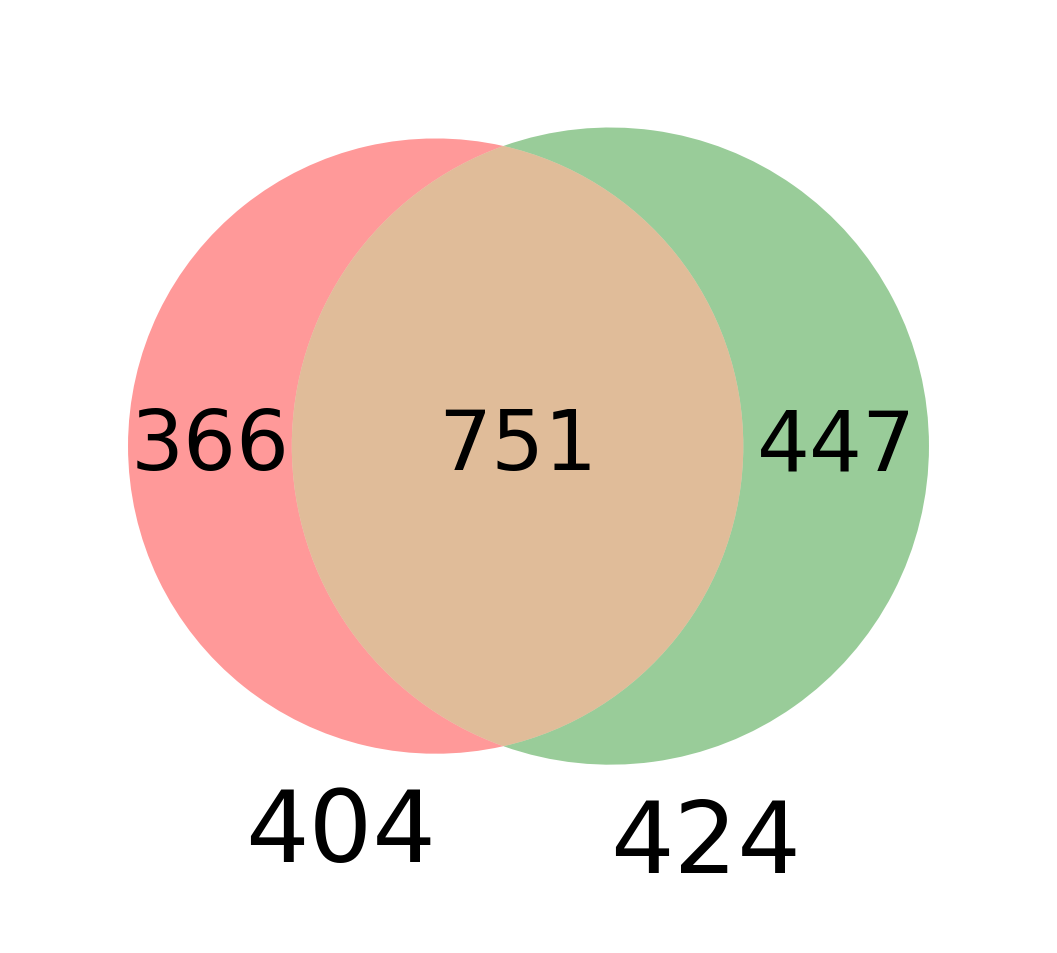

In [18]:
genes_424 = pd.read_csv('snps_sefale/424_all_polymorphism.define_var.txt',index_col=0,sep='\t')
genes_424 = set(genes_424.loc[((genes_424.var_comment=='point nutation Synonymous') | (genes_424.var_comment=='point nutation Non-synonymous'))]['predicted_gene_name'])
genes_404 = pd.read_csv('snps_sefale/404_all_polymorphism.define_var.txt',index_col=0,sep='\t')
genes_404 = set(genes_404.loc[((genes_404.var_comment=='point nutation Synonymous') | (genes_404.var_comment=='point nutation Non-synonymous'))]['predicted_gene_name'])

all_genes = genes_424 | genes_404
all_genes_table = pd.DataFrame(columns=['404','424'])
for gene in all_genes:
    if gene in genes_424:
        all_genes_table.at[gene,'424'] = '+'
    if gene in genes_404:
        all_genes_table.at[gene,'404'] = '+'
all_genes_table = all_genes_table.fillna('-')

def get_sharing(series):
    if series['424'] == '+':
        if series['404'] == '+':
            return 'shared'
        else:
            return '424 Only'
    elif series['404'] == '+':
        return '404 Only'
    else:
        raise RuntimeError('gene nowhere')

all_genes_table['Shared'] = all_genes_table.apply(get_sharing,axis=1)

with open('snps_sefale/shared_genes.txt','a') as hndl:
    hndl.write('# This table contains all the functionally-annotated* genes from Tables S1 and S2 that have at least one SNP identified as point-nutation\n')
    hndl.write('# It corresponds with the genes represented in Figure \n')
    hndl.write('# *functionally-annotated genes are genes with predicted_gene_name in the eggNOG output \n')
    hndl.write('# Shared genes %i\n' % len(all_genes_table.loc[all_genes_table.Shared=='shared']))
    hndl.write('# 404 only %i\n' % len(all_genes_table.loc[all_genes_table.Shared=='404 Only']))
    hndl.write('# 424 only %i\n' % len(all_genes_table.loc[all_genes_table.Shared=='424 Only']))
    hndl.write('# Total %i\n' % len(all_genes_table))
    all_genes_table.to_csv(hndl,sep='\t')

fig, ax = plt.subplots(figsize=(2,2),dpi=600)
venn2([genes_404, genes_424],set_labels = ('404', '424'),ax=ax)
plt.savefig('snps_sefale/venn_shared_genes.png')

### 23. Summarize gain and loss of heterozygocity

In [22]:
sefale = SeqIO.to_dict(SeqIO.parse('celera_assemblies/Sefale.mer22.scf.fasta','fasta'))

var_424 = pd.read_table('snps_sefale/424_all_polymorphism.define_var.txt',index_col=0)
var_424['POS'] = var_424['POS'].astype(int)
var_404 = pd.read_table('snps_sefale/404_all_polymorphism.define_var.txt',index_col=0)
var_404['POS'] = var_404['POS'].astype(int)

LOH_GOH = pd.DataFrame(columns=['SefAle_Heterozygote', 'SefAle_states','404_Heterozygote', '404_states','424_Heterozygote', '424_states','gene','predicted_gene_name'])

for scaffold in sefale:
    var_404_scaff = var_404.loc[var_404['#CHROM'] == scaffold]
    var_424_scaff = var_424.loc[var_424['#CHROM'] == scaffold]
    for i in range(len(sefale[scaffold])):
        pos = i+1
        if len(var_404_scaff) > 0 and pos in var_404_scaff['POS'].tolist():
            var_404_pos = var_404_scaff.loc[var_404_scaff.POS == pos].squeeze()
            sef_het = var_404_pos['SefAle_Heterozygote']
            sef_state = var_404_pos['SefAle_states']
            het_404 = var_404_pos['Heterozygote']
            state_404 = var_404_pos['states']
            gene = var_404_pos['gene']
            gene_name = var_404_pos['predicted_gene_name']
            if len(var_424_scaff) > 0 and pos in var_424_scaff['POS'].tolist():
                var_424_pos = var_424_scaff.loc[var_424_scaff.POS == pos].squeeze()
                het_424 = var_424_pos['Heterozygote']
                state_424 = var_424_pos['states']
            else:
                het_424 = False
                state_424 = str(sefale[scaffold].seq)[i]
        elif len(var_424_scaff) > 0 and pos in var_424_scaff['POS'].tolist():
            var_424_pos = var_424_scaff.loc[var_424_scaff.POS == pos].squeeze()
            sef_het = var_424_pos['SefAle_Heterozygote']
            sef_state = var_424_pos['SefAle_states']
            het_424 = var_424_pos['Heterozygote']
            state_424 = var_424_pos['states']
            gene = var_424_pos['gene']
            gene_name = var_424_pos['predicted_gene_name']
            het_404 = False
            state_404 = str(sefale[scaffold].seq)[i]
        else:
            continue
        LOH_GOH.loc[scaffold+'_'+str(pos)] = [sef_het,sef_state,het_404,state_404,het_424,state_424,gene,gene_name]

In [23]:
LOH_GOH.to_csv('snps_sefale/gain_and_loss_of_heterozygocity_in_descendants.tsv',sep='\t')

### 24. Summarize polymorphism types for Figure 4C

In [24]:
var_404 = pd.read_table('snps_sefale/404_all_polymorphism.define_var.txt',index_col=0)

In [26]:
set(var_404.var_comment)

{'GOH',
 'LOH',
 'codon contains ambiguity symbol',
 'complex mutation',
 'intron',
 'no_gene',
 'point nutation Non-synonymous',
 'point nutation Synonymous',
 'retained heterozygocity'}

In [36]:
var_summary = pd.DataFrame({'404':[0,0,0,0,0,0],'424':[0,0,0,0,0,0]},index=['insertions', 'deletions', 'LOH', 'GOH','homozygouse substitution','other'])

for ind, row in var_404.iterrows():
    if row['var_comment'] == 'GOH':
        var_summary.at['GOH','404'] += 1
    elif row['var_comment'] == 'LOH':
        var_summary.at['LOH','404'] += 1
    elif row['var_comment'] in ['codon contains ambiguity symbol','complex mutation','retained heterozygocity']:
        max_saf = [len(i) for i in row['SefAle_states'].split(',')]
        max_404 = [len(i) for i in row['states'].split(',')]
        if max_saf > max_404:
            var_summary.at['deletions','404'] += 1
        elif max_saf < max_404:
            var_summary.at['insertions','404'] += 1
        else:
            var_summary.at['other','404'] += 1
    elif row['var_comment'] in ['point nutation Non-synonymous','point nutation Synonymous','no_gene','intron']:
        var_summary.at['homozygouse substitution','404'] += 1
        
for ind, row in var_424.iterrows():
    if row['var_comment'] == 'GOH':
        var_summary.at['GOH','424'] += 1
    elif row['var_comment'] == 'LOH':
        var_summary.at['LOH','424'] += 1
    elif row['var_comment'] in ['codon contains ambiguity symbol','complex mutation','retained heterozygocity']:
        max_saf = [len(i) for i in row['SefAle_states'].split(',')]
        max_424 = [len(i) for i in row['states'].split(',')]
        if max_saf > max_424:
            var_summary.at['deletions','424'] += 1
        elif max_saf < max_424:
            var_summary.at['insertions','424'] += 1
        else:
            var_summary.at['other','424'] += 1
    elif row['var_comment'] in ['point nutation Non-synonymous','point nutation Synonymous','no_gene','intron']:
        var_summary.at['homozygouse substitution','424'] += 1
        

In [38]:
var_summary.to_csv('snps_sefale/summary.tsv',sep='\t')

### 25. Make supplementary tables

In [41]:
a = !wget http://eggnogdb.embl.de/download/eggnog_4.5/data/fuNOG/fuNOG.members.tsv.gz
#a = !wget https://downloads.yeastgenome.org/sequence/S288C_reference/orf_protein/orf_trans_all.fasta.gz

members = pd.read_csv('fuNOG.members.tsv.gz',sep='\t', index_col=1,header=None)
Scer_proteins = SeqIO.to_dict(SeqIO.parse(gopen('orf_trans_all.fasta.gz','r'),'fasta'))
stringdb = pd.read_csv('protein.info.v11.0.txt.gz',index_col=0,sep='\t')

a = !rm fuNOG.members.tsv.gz
#a = !rm orf_trans_all.fasta.gz

Scer_orth_search_resuts = pd.DataFrame(columns=['seed_ortholog_gene','seed_ortholog_annotation'])
annot = 'celera_assemblies/Sefale.emapper.annotations'
annot_df = pd.read_table(annot, skiprows=2)

for ind, row in annot_df.iterrows():
    if row['seed_eggNOG_ortholog'] not in Scer_orth_search_resuts.index and not isinstance(row['seed_eggNOG_ortholog'],float):
        Scer_orth_search_resuts.loc[row['seed_eggNOG_ortholog']] = [row['predicted_gene_name'],row['eggNOG annot']]   
Scer_orth_search_resuts

for seed, seed_name_row in tqdm(Scer_orth_search_resuts.iterrows(),total=len(Scer_orth_search_resuts)):
    egg_members = members.loc[members[5].str.contains(seed)][5].tolist()
    if len(egg_members) > 0:
        Scer_orth_search_resuts.at[seed,'members'] = egg_members[0]

def get_scer_ortholog(string):
    orthologs = [i.split('.')[1] for i in string.split(',')]
    scer_ortholog = set(Scer_proteins.keys()).intersection(set(orthologs))
    if len(scer_ortholog) == 0:
        return None
    scer_ortholog = list(scer_ortholog)[0]
    return scer_ortholog

Scer_orth_search_resuts['scer_ortholog'] = Scer_orth_search_resuts.members.apply(get_scer_ortholog)

def get_scer_gen(string):
    if not string:
        return None,None
    description = Scer_proteins[string].description
    gene = description.split(' ')[1]
    return gene

def get_scer_annot(string):
    if not string:
        return None,None
    description = Scer_proteins[string].description
    annot = description.split('"')[-2]
    return annot

Scer_orth_search_resuts['scer_gene'] = Scer_orth_search_resuts.scer_ortholog.apply(get_scer_gen)
Scer_orth_search_resuts['scer_annotation'] = Scer_orth_search_resuts.scer_ortholog.apply(get_scer_annot)

In [88]:
def add_scer_ort(gene):
    
    try:
        seed = annot_df.loc[annot_df['#query_name'] == gene]['seed_eggNOG_ortholog'].tolist()[0]
        return Scer_orth_search_resuts.at[seed,'scer_ortholog']
    except: 
        return None
    
def add_scer_gene_name(gene):
    
    try:
        seed = annot_df.loc[annot_df['#query_name'] == gene]['seed_eggNOG_ortholog'].tolist()[0]
        return Scer_orth_search_resuts.at[seed,'scer_gene']
    except: 
        return None
    
def add_scer_gene_annot(gene):
    
    try:
        seed = annot_df.loc[annot_df['#query_name'] == gene]['seed_eggNOG_ortholog'].tolist()[0]
        return Scer_orth_search_resuts.at[seed,'scer_annotation']
    except: 
        return None
    
def seed_and_scer_names_same(series):
    if not series['predicted_gene_name'] and not series['Scer_gene_name']:
        return None
    try:
        return series['predicted_gene_name'] == series['Scer_gene_name']
    except:
        return None
    

for f in glob.glob('snps_sefale/*_all_polymorphism.define_var.txt'):
    df = pd.read_csv(f,sep='\t',index_col=0)
    df['Scer_ortholog'] = df.gene.apply(add_scer_ort)
    df['Scer_gene_name'] = df.gene.apply(add_scer_gene_name)
    df['Scer_gene_annot'] = df.gene.apply(add_scer_gene_annot)
    df['Same_gene_name'] = df.apply(seed_and_scer_names_same,axis=1)
    df.to_csv(f.replace('define_var','scer_info'),sep='\t')
    

#### Table S1

In [124]:
columns = ['SCAFF in SafAle','POS','REF','ALT','DP','TYPE',
           '404 is Heterozygote','SefAle is Heterozygote',
           '404 states', 'SefAle states',
           'Gene Name', 'Comment']

tabS1 = pd.DataFrame(columns=columns)

included_columns = ['#CHROM','POS','REF','ALT',
                    'DP','TYPE','Heterozygote',
                    'SefAle_Heterozygote','states',
                    'SefAle_states','predicted_gene_name',
                    'var_comment']

original_output = pd.read_csv('snps_sefale/404_all_polymorphism.scer_info.txt',sep='\t',index_col=0)

#LOH loss of heterozygosity through deletion or through homologous/non-hologous recombination 
#GOH gain of heterozygosty through point mutation
#complex mutation - indel of one or more bases
#No-gene LOH loss of heterozygosity outside detected genes
#No-gene GOH gain of heterozygosity outside detected genes  

var_comment = {
    'GOH':'GOH',
    'LOH':'LOH',
    'codon contains ambiguity symbol':'Codon contains ambiguity symbol',
    'complex mutation':'Complex mutation',
    'intron':'Intron',
    'no_gene':'No_gene',
    'point nutation Non-synonymous':'Point nutation Non-synonymous, homozygous to homozygous',
    'point nutation Synonymous':'Point nutation Synonymous, homozygous to homozygous',
    'retained heterozygocity':'Retained heterozygosity'
}

for ind, row in original_output.iterrows():
    new_row = [row['#CHROM'],row['POS'],row['REF'],row['ALT'],
               row['DP'],row['TYPE'],row['Heterozygote'],
               row['SefAle_states'],row['states'],row['SefAle_states']]
    if isinstance(row['predicted_gene_name'],float):
        new_row.append(row['predicted_gene_name'])
    elif row['predicted_gene_name'].startswith('FG1'):
           new_row.append(row['Scer_gene_name'])
    elif row['predicted_gene_name'].startswith('FG0'):
        new_row.append(row['Scer_gene_name'])
    elif row['predicted_gene_name'].startswith('PGUG'):
        new_row.append(row['Scer_gene_name'])
    elif row['predicted_gene_name'].startswith('FGSG'):
        new_row.append(row['Scer_gene_name'])
    else:
        new_row.append(row['predicted_gene_name'])
    if row['var_comment'] == 'no_gene':
        if row['SefAle_Heterozygote'] and not row['Heterozygote']:
            new_row.append('No-gene LOH')
        elif not row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('No-gene GOH')
        elif row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('No-gene Retained heterozygosity')
        else:
            new_row.append('No-gene')
    elif row['var_comment'] == 'intron':
        if row['SefAle_Heterozygote'] and not row['Heterozygote']:
            new_row.append('Intron LOH')
        elif not row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('Intron GOH')
        elif row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('Intron Retained heterozygosity')
        else:
            new_row.append('Intron')
    else:
        new_row.append(var_comment[row['var_comment']])
        
    tabS1.loc[ind] = new_row
    

with open('TableS1_iScience_changes_in_Sc404_gene.tsv','a') as hndl:
    hndl.write('### LEGEND\n')
    hndl.write('## SCAFF in SafAle: Scaffold ID in the SafAle denovo assembly\n')
    hndl.write('## POS: Position on SCAFF\n')
    hndl.write('## REF: Consensus character state in the SafAle denovo assembly (inherited from the VCF file)\n')
    hndl.write('## ALT: Additional character states in 404 based on BWA output (inherited from the VCF file)\n')
    hndl.write('## DP: Coverage (inherited from the VCF file)\n')
    hndl.write('## TYPE: Variant type, snp or complex (inherited from the VCF file)\n')
    hndl.write('## 404 is Heterozygote: Descendant is Heterozygote - True or False  \n')
    hndl.write('## SefAle is Heterozygote: Ancestor is Heterozygote - True or False \n')
    hndl.write('## 404 states: Infered from VCF resulting from mapping Descendant reads to SefAle genome \n')
    hndl.write('## SefAle states: Infered from VCF resulting from mapping SefAle reads to SefAle genome \n')
    hndl.write('## Gene Name: Inherited from eggNOG orthologs or SGD \n')
    hndl.write('## Comment: \n')
    hndl.write('# LOH: Loss of heterozygosity through deletion or through homologous/non-hologous recombination\n')
    hndl.write('# GOH: Gain of heterozygosity through point mutation \n')
    hndl.write('# Complex mutation: Indel of one or more bases \n')
    hndl.write('# No-gene LOH: Loss of heterozygosity outside detected genes \n')
    hndl.write('# No-gene GOH: Gain of heterozygosity outside detected genes \n')
    hndl.write('# No-gene: SNP outside detected genes, zygocity retained \n')
    hndl.write('# Intron LOH: Loss of heterozygosity in intron \n')
    hndl.write('# Intron GOH: Gain of heterozygosity in intron \n')
    hndl.write('# Intron: SNP in intron, zygocity retained \n')
    hndl.write('# Codon contains ambiguity symbol: Inference avoided due to uncertainty \n')
    hndl.write('# Point nutation Non-synonymous, homozygous to homozygous \n')
    hndl.write('# Point nutation Synonymous, homozygous to homozygous \n')
    hndl.write('# Retained heterozygosity \n')
    tabS1.to_csv(hndl,sep='\t')

#### Table S2

In [125]:
columns = ['SCAFF in SafAle','POS','REF','ALT','DP','TYPE',
           '424 is Heterozygote','SefAle is Heterozygote',
           '424 states', 'SefAle states',
           'Gene Name', 'Comment']

tabS2 = pd.DataFrame(columns=columns)

included_columns = ['#CHROM','POS','REF','ALT',
                    'DP','TYPE','Heterozygote',
                    'SefAle_Heterozygote','states',
                    'SefAle_states','predicted_gene_name',
                    'var_comment']

original_output = pd.read_csv('snps_sefale/424_all_polymorphism.scer_info.txt',sep='\t',index_col=0)

#LOH loss of heterozygosity through deletion or through homologous/non-hologous recombination 
#GOH gain of heterozygosity through point mutation
#complex mutation - indel of one or more bases
#No-gene LOH loss of heterozygosity outside detected genes
#No-gene GOH gain of heterozygosity outside detected genes  

var_comment = {
    'GOH':'GOH',
    'LOH':'LOH',
    'codon contains ambiguity symbol':'Codon contains ambiguity symbol',
    'complex mutation':'Complex mutation',
    'intron':'Intron',
    'no_gene':'No_gene',
    'point nutation Non-synonymous':'Point nutation Non-synonymous, homozygous to homozygous',
    'point nutation Synonymous':'Point nutation Synonymous, homozygous to homozygous',
    'retained heterozygocity':'Retained heterozygosity'
}

for ind, row in original_output.iterrows():
    new_row = [row['#CHROM'],row['POS'],row['REF'],row['ALT'],
               row['DP'],row['TYPE'],row['Heterozygote'],
               row['SefAle_states'],row['states'],row['SefAle_states']]
    if (not isinstance(row['predicted_gene_name'],float) and
        (row['predicted_gene_name'].startswith('FG1') or 
         row['predicted_gene_name'].startswith('FG0') or
         row['predicted_gene_name'].startswith('PGUG') or 
         row['predicted_gene_name'].startswith('FGSG'))):
        new_row.append(row['Scer_gene_name'])
    else:
        new_row.append(row['predicted_gene_name'])
    if row['var_comment'] == 'no_gene':
        if row['SefAle_Heterozygote'] and not row['Heterozygote']:
            new_row.append('No-gene LOH')
        elif not row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('No-gene GOH')
        elif row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('No-gene Retained heterozygosity')
        else:
            new_row.append('No-gene')
    elif row['var_comment'] == 'intron':
        if row['SefAle_Heterozygote'] and not row['Heterozygote']:
            new_row.append('Intron LOH')
        elif not row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('Intron GOH')
        elif row['SefAle_Heterozygote'] and row['Heterozygote']:
            new_row.append('Intron Retained heterozygosity')
        else:
            new_row.append('Intron')
    else:
        new_row.append(var_comment[row['var_comment']])
        
    tabS2.loc[ind] = new_row
    
with open('TableS2_iScience_changes_in_Sc424_gene.tsv','a') as hndl:
    hndl.write('### LEGEND\n')
    hndl.write('## SCAFF in SafAle: Scaffold ID in the SafAle denovo assembly\n')
    hndl.write('## POS: Position on SCAFF\n')
    hndl.write('## REF: Consensus character state in the SafAle denovo assembly (inherited from the VCF file)\n')
    hndl.write('## ALT: Additional character states in 404 based on BWA output (inherited from the VCF file)\n')
    hndl.write('## DP: Coverage (inherited from the VCF file)\n')
    hndl.write('## TYPE: Variant type, snp or complex (inherited from the VCF file)\n')
    hndl.write('## 424 is Heterozygote: Descendant is Heterozygote - True or False  \n')
    hndl.write('## SefAle is Heterozygote: Ancestor is Heterozygote - True or False \n')
    hndl.write('## 424 states: Infered from VCF resulting from mapping Descendant reads to SefAle genome \n')
    hndl.write('## SefAle states: Infered from VCF resulting from mapping SefAle reads to SefAle genome \n')
    hndl.write('## Gene Name: Inherited from eggNOG orthologs or SGD \n')
    hndl.write('## Comment: \n')
    hndl.write('# LOH: Loss of heterozygosity through deletion or through homologous/non-hologous recombination\n')
    hndl.write('# GOH: Gain of heterozygosity through point mutation \n')
    hndl.write('# Complex mutation: Indel of one or more bases \n')
    hndl.write('# No-gene LOH: Loss of heterozygosity outside detected genes \n')
    hndl.write('# No-gene GOH: Gain of heterozygosity outside detected genes \n')
    hndl.write('# No-gene: SNP outside detected genes, zygocity retained \n')
    hndl.write('# Intron LOH: Loss of heterozygosity in intron \n')
    hndl.write('# Intron GOH: Gain of heterozygosity in intron \n')
    hndl.write('# Intron: SNP in intron, zygocity retained \n')
    hndl.write('# Codon contains ambiguity symbol: Inference avoided due to uncertainty \n')
    hndl.write('# Point nutation Non-synonymous, homozygous to homozygous \n')
    hndl.write('# Point nutation Synonymous, homozygous to homozygous \n')
    hndl.write('# Retained heterozygosity \n')
    tabS2.to_csv(hndl,sep='\t')

### Table S3

In [132]:
original_output = pd.read_csv('snps_sefale/gain_and_loss_of_heterozygocity_in_descendants.tsv',sep='\t',index_col=0)
for ind, row in original_output.iterrows():
    if (not isinstance(row['predicted_gene_name'],float) and
        (row['predicted_gene_name'].startswith('FG1') or 
         row['predicted_gene_name'].startswith('FG0') or
         row['predicted_gene_name'].startswith('PGUG') or 
         row['predicted_gene_name'].startswith('FGSG'))):
        gene = row['gene']
        #annot_df = annot_df.set_index('#query_name')
        seed = annot_df.at[gene,'seed_eggNOG_ortholog']
        scer_gene_name = Scer_orth_search_resuts.at[seed,'scer_gene']
        original_output.at[ind,'predicted_gene_name'] = scer_gene_name
original_output.to_csv('TableS3_iScience_heterozygosity.tsv',sep='\t')

### Second tab in Tables S1 and S2

In [150]:
genes_df = Scer_orth_search_resuts.loc[:,['seed_ortholog_gene','scer_gene']]

convert = {}

genes_df = genes_df.loc[((genes_df.seed_ortholog_gene.str.startswith('FG1')) | 
                         (genes_df.seed_ortholog_gene.str.startswith('FG0')) |
                         (genes_df.seed_ortholog_gene.str.startswith('PGUG')) |
                         (genes_df.seed_ortholog_gene.str.startswith('FGSG')))]

for ind ,row in genes_df.iterrows():
    try:
        convert[row['seed_ortholog_gene']].add(row['scer_gene'])
    except:
        convert[row['seed_ortholog_gene']]= {row['scer_gene']}
        
original_output = pd.read_csv('snps_sefale/shared_genes.txt',sep='\t',comment='#')

for ind, row in original_output.iterrows():
    if row['Unnamed: 0'] in convert:
        original_output.at[ind,'Unnamed: 0'] = list(convert[row['Unnamed: 0']])[0]

with open('TablesS1andS2_second_tab.tsv','a') as hndl:
    hndl.write("""# This table contains all the functionally-annotated* genes from Tables S1 and S2 that have at least one SNP identified as point-nutation
# It corresponds with the genes represented in Figure 
# *functionally-annotated genes are genes with predicted_gene_name in the eggNOG output 
# Shared genes 751
# 404 only 366
# 424 only 447
# Total 1564
""")
    original_output.to_csv(hndl,sep='\t')